<a href="https://colab.research.google.com/github/FeliciaChin/Text-Classification-for-Major-Depressive-Disorder-MDD-Symptoms-and-Treatments-Using-Convolutional-/blob/main/Text_Classification_for_Major_Depressive_Disorder_(MDD)_Symptoms_and_Treatments_Using_Convolutional_Neural_Networks_(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installation of Package

In [1]:
!pip install biopython
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 16.1 MB/s eta 0:00:00


# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import gensim
import os
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

# Dataset Collection
from Bio import Entrez
from google.colab import files

# importing libraries
import tensorflow as tf
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import Dense, Input, Embedding, Dropout, SpatialDropout1D, Activation, Conv1D, GlobalMaxPool1D, BatchNormalization, Add
from keras.optimizers import Adam
from keras.models import Model, Sequential
from sklearn.model_selection  import train_test_split

# For custom metrics
import keras.backend as K
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

# Visualization
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Download required resources for NLTK
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

#Data Collection and Data Preprocessing

##Dataset Collection

In [4]:
# Set your email address (required by NCBI)
Entrez.email = "feliciac552@gmail.com"

# Define search terms
search_terms = "major depressive disorder AND symptoms AND treatments"
start_year = "2019"
end_year = "2023"

# Perform the search
handle = Entrez.esearch(db="pubmed", term=search_terms, retmax=5000, mindate=start_year, maxdate=end_year)
record = Entrez.read(handle)
handle.close()

In [5]:
id_list = record["IdList"]
summary_records = []

# Create a list to store the extracted data
data = []

# Create a set to store the processed PMIDs
processed_pmids = set()

for article_id in id_list:
  if article_id in processed_pmids:
      continue

  try:
      handle = Entrez.efetch(db='pubmed', id=article_id, retmode='xml')
      article = Entrez.read(handle)['PubmedArticle'][0]
      handle.close()

      title = article['MedlineCitation']['Article']['ArticleTitle']
      abstract = article['MedlineCitation']['Article'].get('Abstract', {}).get('AbstractText', '')

      # Convert abstract to string
      abstract = str(abstract)

      # Append the extracted data to the list
      data.append({'Title': title, 'Abstract':abstract})

  except Exception as e:
        print(f"Error occurred for article ID {article_id}: {str(e)}")
        continue


Error occurred for article ID 32491666: list index out of range
Error occurred for article ID 29493988: list index out of range
Error occurred for article ID 30422576: list index out of range
Error occurred for article ID 35015441: list index out of range
Error occurred for article ID 32119472: list index out of range
Error occurred for article ID 33232071: list index out of range
Error occurred for article ID 30285348: list index out of range
Error occurred for article ID 30335340: list index out of range
Error occurred for article ID 36508518: list index out of range
Error occurred for article ID 38620361: list index out of range
Error occurred for article ID 36049038: list index out of range
Error occurred for article ID 35977058: list index out of range
Error occurred for article ID 37494523: list index out of range
Error occurred for article ID 35344311: list index out of range
Error occurred for article ID 25905229: list index out of range


In [6]:
import csv
# Specify the output CSV file path
csv_file = 'major_depressive_disorder_datasets.csv'

# Write the data to the CSV file
with open(csv_file, 'w', newline='') as file:
    fieldnames = ['Title', 'Abstract']
    writer = csv.DictWriter(file, fieldnames=fieldnames)

    writer.writeheader()
    writer.writerows(data)

print("Data saved to:", csv_file)

Data saved to: major_depressive_disorder_datasets.csv


In [ ]:
from google.colab import files

# Download the file
files.download('major_depressive_disorder_datasets.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Splitting Abstract into Sentences

In [7]:
# Upload dataset
uploaded = files.upload()

# Get the file name
file_name = list(uploaded.keys())[0]
# Read the CSV file
df = pd.read_csv(file_name)

Saving major_depressive_disorder_datasets.csv to major_depressive_disorder_datasets (1).csv


In [8]:
df.shape

(4984, 2)

In [11]:
df.head(10)

,Title,Abstract
0,Prevalence of and optimal screening tool for p...,[StringElement('Postpartum depression (PPD) is...
1,Impact of living with an adult with depressive...,[StringElement('The effect of depressive sympt...
2,Longitudinal Clusters of Long-Term Trajectorie...,"[StringElement('In clinical trials, mostly gro..."
3,Evaluating real-world effectiveness of acceler...,[StringElement('To assess the effectiveness of...
4,A prospective cohort study to assess the preva...,"[""Antepartum depression (APD) is a public heal..."
5,Effect of Psychological and Medication Therapi...,[StringElement('Daytime functional impairments...
6,Long-Term Safety and Efficacy of Initial and R...,['<b><i>Objective:</i></b> Zuranolone is a pos...
7,Impact of deep transcranial magnetic stimulati...,[StringElement('Deep transcranial magnetic sti...
8,Female-specific pharmacotherapy in ADHD: preme...,[StringElement('Attention-Deficit/Hyperactivit...
9,GABAA Receptor Availability in Relation to Cor...,[StringElement('Gamma-aminobutyric acid (GABA)...


In [12]:
# Split abstract into sentences
sentences_list = []
for abstract in df["Abstract"]:
    sentences = nltk.sent_tokenize(str(abstract))
    sentences_list.extend(sentences)

# Create a new DataFrame with only the sentences column
sentences_df = pd.DataFrame(sentences_list, columns=["sentences"])

# Save the sentences DataFrame to a new CSV file
sentences_df.to_csv("mdd_sentences_dataset.csv", index=False)


In [13]:
# Download the CSV file
files.download("mdd_sentences_dataset.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
sentences_df.head(10)

,sentences
0,[StringElement('Postpartum depression (PPD) is...
1,China is planning to launch PPD screening in c...
2,"', attributes={'Label': 'BACKGROUND', 'NlmCate..."
3,Video structured diagnostic interviews were pe...
4,Optimal screening was determined based on the ...
5,"', attributes={'Label': 'METHODS', 'NlmCategor..."
6,"Among those screened, the video structured dia..."
7,The optimal screening approach involved combin...
8,"', attributes={'Label': 'RESULTS', 'NlmCategor..."
9,"', attributes={'Label': 'LIMITATIONS', 'NlmCat..."


## Text preprocessing

In [15]:
# Check for NaN values in the DataFrame
nan_values = sentences_df.isnull().sum()

# Print the number of NaN values for each column
print(nan_values)


sentences    0
dtype: int64


In [ ]:
# Remove rows with NaN values
sentences_df.dropna(subset=["sentences"], inplace=True)

In [16]:
# Re-check for NaN values in the DataFrame
nan_values = sentences_df.isnull().sum()

# Print the number of NaN values for each column
print(nan_values)

sentences    0
dtype: int64


In [17]:
# Preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a string
    processed_text = " ".join(tokens)

    return processed_text

# Apply preprocessing to the "sentences" column
sentences_df["sentences"] = sentences_df["sentences"].apply(preprocess_text)

# Save the preprocessed data to a CSV file
sentences_df.to_csv("mdd_preprocessed_data.csv", index=False)


In [18]:
sentences_df.head(10)

,sentences
0,stringelementpostpartum depression ppd importa...
1,china planning launch ppd screening community ...
2,attributeslabel background nlmcategory backgro...
3,video structured diagnostic interview performe...
4,optimal screening determined based acceptabili...
5,attributeslabel method nlmcategory method stri...
6,among screened video structured diagnostic int...
7,optimal screening approach involved combining ...
8,attributeslabel result nlmcategory result stri...
9,attributeslabel limitation nlmcategory conclus...


In [ ]:
# Download the CSV file
files.download("mdd_preprocessed_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
uploaded = files.upload()

preprocessed_df = pd.read_csv('mdd_preprocessed_data.csv')

Saving mdd_sentences_dataset.csv to mdd_sentences_dataset.csv


In [19]:
preprocessed_df = pd.read_csv('mdd_preprocessed_data.csv')

In [20]:
# Chekcing null values in the dataset
preprocessed_df.isnull().sum()

sentences    138
dtype: int64

In [21]:
# Drop the column
preprocessed_df.dropna(subset=['sentences'], inplace=True)

# Resetting the index
preprocessed_df.reset_index(drop=True, inplace=True)

In [22]:
# recheck null values in the dataset
preprocessed_df.isnull().sum()

sentences    0
dtype: int64

In [23]:
preprocessed_df.shape

(58461, 1)

##Dataset Labeling

In [24]:
# Define the symptoms and treatments keywords
symptoms_keywords = [
    "Aches",
    "pains",
    "Anxious",
    "Appetite changes",
    "Cramps",
    "decreased concentration",
    "Decreased energy",
    "depressed mood",
    "Difficulty concentrating",
    "Difficulty making decisions",
    "Difficulty Remembering",
    "Difficulty sleeping",
    "digestive problems without a clear physical cause",
    "disrupted sleep",
    "do not ease even with treatment",
    "early-morning awakening",
    "empty mood",
    "excessive guilt",
    "fatigue",
    "Feeling restless",
    "feeling very tired",
    "feelings of excessive guilt",
    "Feelings of guilt",
    "Feelings of hopelessness",
    "having trouble sitting still",
    "headaches",
    "helplessness",
    "hopelessness about the future",
    "hypersomnia",
    "Insomnia",
    "Irritability",
    "Loss of interest",
    "loss of pleasure",
    "low in energy",
    "low self-worth",
    "oversleeping",
    "Persistent sadness",
    "pessimism",
    "poor concentration",
    "psychomotor agitation",
    "retardation",
    "suicide attempts",
    "thoughts about dying",
    "thoughts of suicide",
    "weight changes",
    "weight gain",
    "weight loss",
    "Worthlessness"
]


treatments_keywords = [
    "antidepressants",
    "Atypical antidepressants",
    "behavioural activation",
    "cognitive behavioural therapy",
    "Electroconvulsive therapy",
    "ECT"
    "fluoxetine",
    "interpersonal psychotherapy",
    "Monoamine oxidase inhibitors",
    "MAOIs",
    "neuromodulation",
    "problem-solving therapy",
    "Psychotherapy",
    "Selective serotonin reuptake inhibitors",
    "SSRIs",
    "Serotonin-norepinephrine reuptake inhibitors",
    "SNRIs",
    "Transcranial magnetic stimulation",
    "Tricyclic antidepressants"
]


In [25]:
# Preprocessing keywords
def preprocess_keyword(text):
    # Convert text to lowercase
    text = text.lower()

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a string
    processed_keywords = " ".join(tokens)

    return processed_keywords


# Preprocess the keywords using the preprocess_text function
symptoms_keywords = [preprocess_keyword(keyword) for keyword in symptoms_keywords]
treatments_keywords = [preprocess_keyword(keyword) for keyword in treatments_keywords]


In [ ]:
# Print the keywords
print("Preprocessed Symptoms Keywords:")
for keyword in symptoms_keywords:
    print(keyword)

print("\nPreprocessed Treatments Keywords:")
for keyword in treatments_keywords:
    print(keyword)

Preprocessed Symptoms Keywords:
ache
pain
anxious
appetite change
cramp
decreased concentration
decreased energy
depressed mood
difficulty concentrating
difficulty making decision
difficulty remembering
difficulty sleeping
digestive problem without clear physical cause
disrupted sleep
ease even treatment
early-morning awakening
empty mood
excessive guilt
fatigue
feeling restless
feeling tired
feeling excessive guilt
feeling guilt
feeling hopelessness
trouble sitting still
headache
helplessness
hopelessness future
hypersomnia
insomnia
irritability
loss interest
loss pleasure
low energy
low self-worth
oversleeping
persistent sadness
pessimism
poor concentration
psychomotor agitation
retardation
suicide attempt
thought dying
thought suicide
weight change
weight gain
weight loss
worthlessness

Preprocessed Treatments Keywords:
antidepressant
atypical antidepressant
behavioural activation
cognitive behavioural therapy
electroconvulsive therapy
ectfluoxetine
interpersonal psychotherapy
monoa

In [26]:
labeled_data = pd.DataFrame()
labeled_data['sentences'] = preprocessed_df['sentences']

In [27]:
# Resetting index of labeled_data
labeled_data.reset_index(drop=True, inplace=True)

In [28]:
labeled_data.shape

(58461, 1)

In [29]:
labeled_data.isnull().sum()

sentences    0
dtype: int64

In [31]:
sentences = preprocessed_df['sentences']

# Create a new column for labels
labeled_data['label'] = 0

# Initialize dictionaries to store the matched symptom and treatment words for each sentence
symptom_words_dict = {}
treatment_words_dict = {}

# Define a function to get the n-gram of a keyword
def get_keyword_ngram(keyword):
    # Split the keyword by spaces and count the number of elements
    ngram = len(keyword.split())
    return ngram

# Loop through the test sentences
for i, sentence in enumerate(sentences,0):
    # Tokenize the preprocessed sentence into words
    words = nltk.word_tokenize(sentence)

    if sentence != labeled_data.loc[i, 'sentences']:
        print(f"Sentence {i}: {sentence}")

    # Initialize flags for symptom and treatment
    symptom_flag = False
    treatment_flag = False

    # Initialize lists to store the matched symptom and treatment words for this sentence
    symptom_words_dict[i] = []
    treatment_words_dict[i] = []

    # Loop through the keywords
    for keyword in symptoms_keywords + treatments_keywords:
        # Preprocess the keyword and get the n-gram
        ngram = get_keyword_ngram(keyword)

        # Generate n-grams of the appropriate length
        sentence_ngrams = list(ngrams(words, ngram))

        # Check if the keyword is in the sentence n-grams
        for gram in sentence_ngrams:
            if keyword == ' '.join(gram):
                matched_word = ' '.join(gram)
                if keyword in symptoms_keywords:
                    symptom_flag = True
                    symptom_words_dict[i].append(matched_word)  # Store the matched word
                if keyword in treatments_keywords:
                    treatment_flag = True
                    treatment_words_dict[i].append(matched_word)  # Store the matched word

    # Assign labels and print the results for label 3 only
    if symptom_flag and treatment_flag:
        labeled_data.loc[i, 'label'] = 3
    elif symptom_flag:
        labeled_data.loc[i, 'label'] = 1
    elif treatment_flag:
        labeled_data.loc[i, 'label'] = 2
    elif not symptom_flag and not treatment_flag:
        labeled_data.loc[i, 'label'] = 0

In [32]:
labeled_data.head(10)

,sentences,label
0,stringelementpostpartum depression ppd importa...,0
1,china planning launch ppd screening community ...,0
2,attributeslabel background nlmcategory backgro...,0
3,video structured diagnostic interview performe...,0
4,optimal screening determined based acceptabili...,0
5,attributeslabel method nlmcategory method stri...,0
6,among screened video structured diagnostic int...,0
7,optimal screening approach involved combining ...,0
8,attributeslabel result nlmcategory result stri...,0
9,attributeslabel limitation nlmcategory conclus...,0


In [ ]:
# Save the DataFrame to a CSV file
labeled_data.to_csv('mdd_labeled_data.csv', index=False)
from google.colab import files

# Download the file
files.download('mdd_labeled_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Exploratory Data Analysis

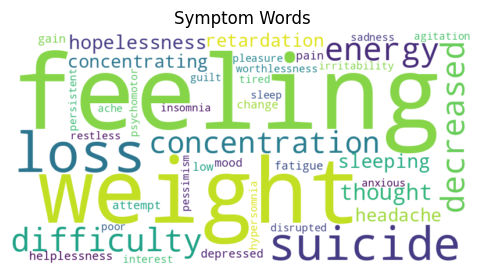

In [33]:
# Flatten the symptom_words_dict into a list
symptom_words_flat = [word for words in symptom_words_dict.values() for word in words]
treatment_words_flat = [word for words in treatment_words_dict.values() for word in words]

# Remove duplicate occurrences
symptom_words_unique = list(set(symptom_words_flat))
treatment_words_unique = list(set(treatment_words_flat))

# Generate word cloud for symptom words without duplicates
symptom_wordcloud_unique = WordCloud(width=800, height=400, background_color='white').generate(' '.join(symptom_words_unique))
treatment_wordcloud_unique = WordCloud(width=800, height=400, background_color='white').generate(' '.join(treatment_words_unique))

# Plot the symptoms word cloud
plt.figure(figsize=(6, 4))
plt.imshow(symptom_wordcloud_unique, interpolation='bilinear')
plt.title('Symptom Words')
plt.axis('off')
plt.show()


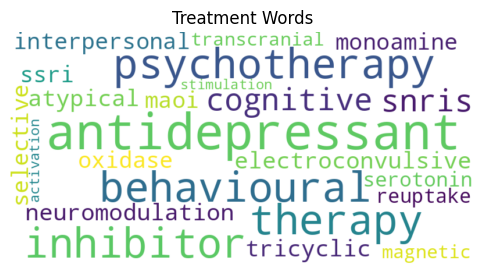

In [ ]:
# Plot the treatments word cloud
plt.figure(figsize=(6, 4))
plt.imshow(treatment_wordcloud_unique, interpolation='bilinear')
plt.title('Treatment Words')
plt.axis('off')
plt.show()

In [ ]:
# Count the occurrences of each label
label_counts = labeled_data['label'].value_counts()
print(label_counts)

label
0    53271
2     3399
1     1707
3       84
Name: count, dtype: int64


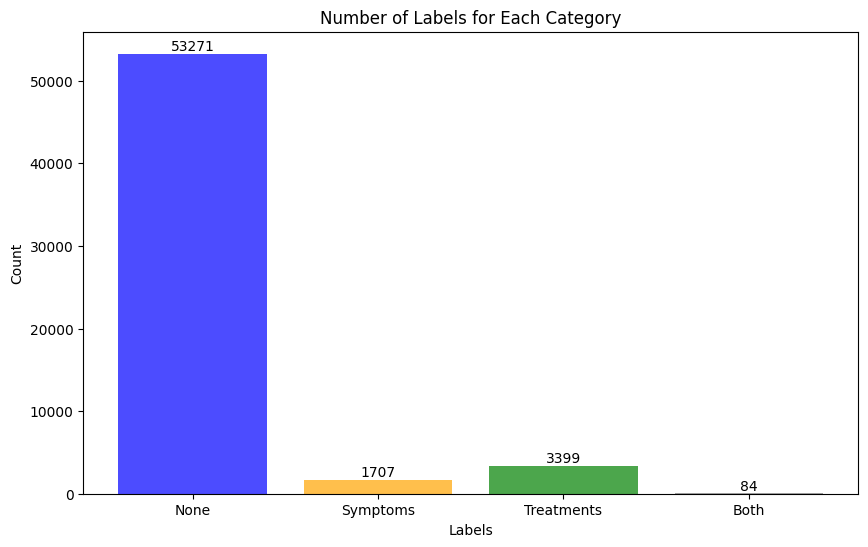

In [ ]:
# Create a bar chart with different colors for each label
colors = ['blue', 'green', 'orange', 'grey']
plt.figure(figsize=(10, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=colors, alpha=0.7)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Number of Labels for Each Category')
plt.xticks([0, 1, 2, 3], ['None', 'Symptoms', 'Treatments', 'Both'])

# Add counts above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

plt.show()


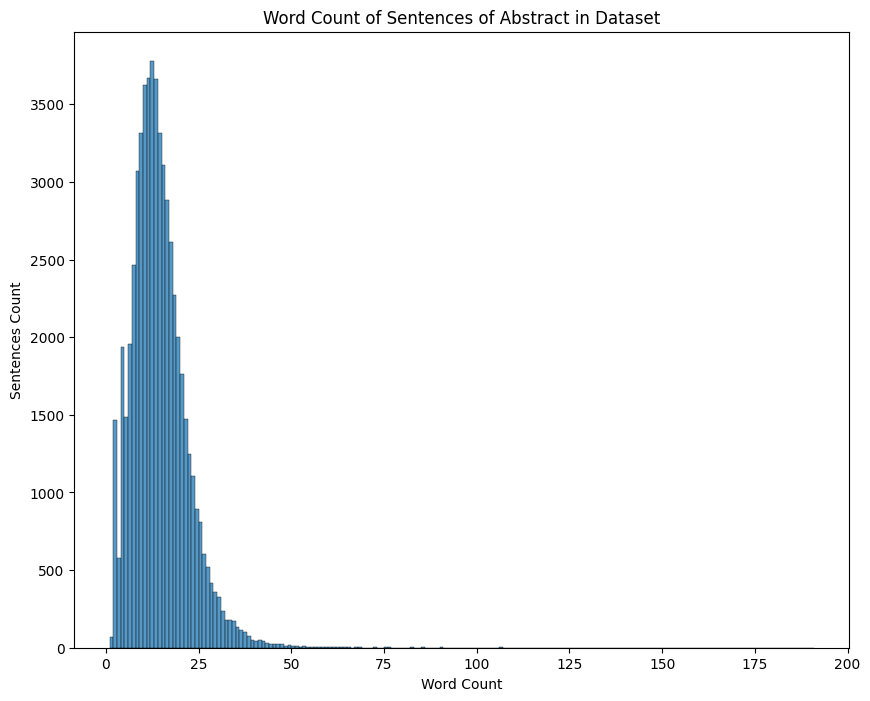

In [ ]:
# Calculate word count
word_count = labeled_data['sentences'].apply(lambda x: len(str(x).split()))

# Create histogram
plt.figure(figsize=(10,8))
hist = sns.histplot(data=labeled_data, x=word_count, binwidth=1)

plt.title('Word Count of Sentences of Abstract in Dataset')
plt.xlabel('Word Count')
plt.ylabel('Sentences Count')
plt.show()


In [ ]:
max_word_count = word_count.max()
print("The maximum word count is:", max_word_count)

The maximum word count is: 191


In [ ]:
sentences = (sum(word_count < 100)/labeled_data.shape[0])*100
print('Percentage of sentences having less than 100 Words:{:.2f}%'.format(sentences))


Percentage of sentences having less than 100 Words:99.99%


##Handle Imbalance Dataset

In [ ]:
from google.colab import files

uploaded = files.upload()

# Get the file name
file_name = list(uploaded.keys())[0]


Saving mdd_labeled_data.csv to mdd_labeled_data.csv


In [ ]:
# Read the CSV file
df = pd.read_csv(file_name)

In [ ]:
df.shape

(58461, 2)

In [ ]:
# Count the occurrences of each label
label_counts = df['label'].value_counts()
print(label_counts)

label
0    53271
2     3399
1     1707
3       84
Name: count, dtype: int64


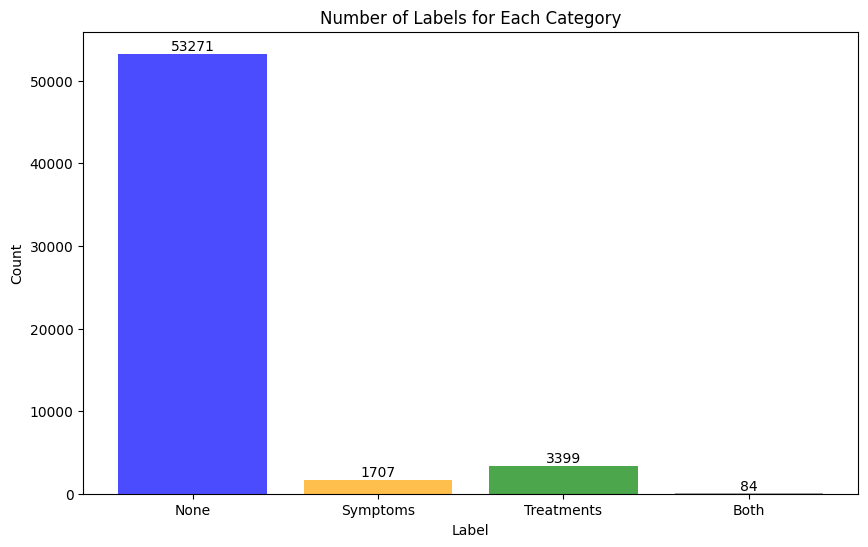

In [ ]:
# Create a bar chart with different colors for each label
colors = ['blue', 'green', 'orange', 'grey']
plt.figure(figsize=(10, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=colors, alpha=0.7)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Number of Labels for Each Category')
plt.xticks([0, 1, 2, 3], ['None', 'Symptoms', 'Treatments', 'Both'])

# Add counts above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

plt.show()




*   There dataset is imbalanced, the 'None' category will undergo undersampling (resampling) to be reduced to 5000. Values of 5000 is chosen to sum the total of dataset to around ten thousands.

*   For the 'both' category, it will be removed since the amount of values is too small and it does not have significant impact for the model to achieve the research's objectives.


In [ ]:
# remove the 'Both' category inside the dataset
df = df[df['label'] != 3]

In [ ]:
# Count the occurrences of each label
label_counts = df['label'].value_counts()
print(label_counts)

label
0    53271
2     3399
1     1707
Name: count, dtype: int64


In [ ]:
none_treatment_symptoms = df[(df['label'] == 0)]
other_classes = df[(df['label'] != 0)]

# Randomly sample instances from 'none treatment and symptoms' class
reduced_none_treatment_symptoms = none_treatment_symptoms.sample(n=5000, random_state=1)

# Concatenate the reduced 'none treatment and symptoms' DataFrame wth the other classes DataFrame
balanced_df = pd.concat([reduced_none_treatment_symptoms, other_classes])

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=1).reset_index(drop=True)


In [ ]:
# Count the occurrences of each label
counts = balanced_df['label'].value_counts()
print(counts)

label
0    5000
2    3399
1    1707
Name: count, dtype: int64


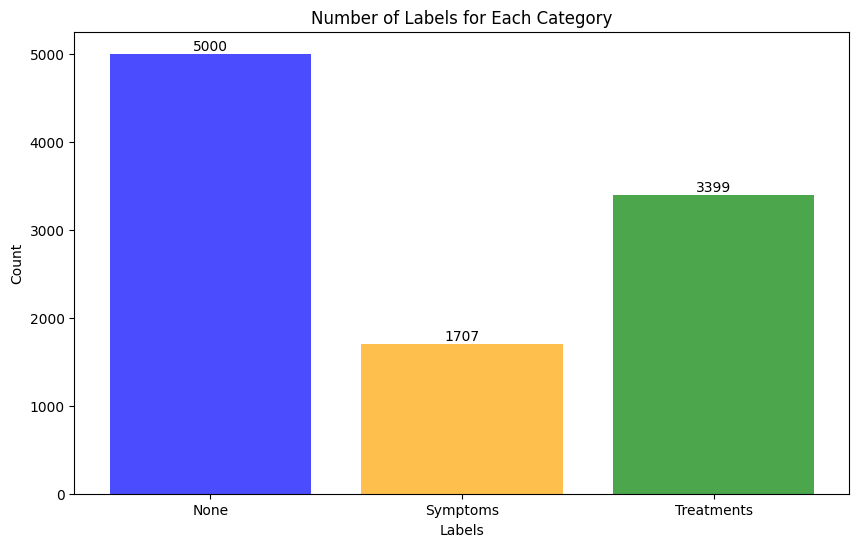

In [ ]:
# Create a bar chart with different colors for each label
colors = ['blue', 'green', 'orange']
plt.figure(figsize=(10, 6))
bars = plt.bar(counts.index, counts.values, color=colors, alpha=0.7)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Number of Labels for Each Category')
plt.xticks([0, 1, 2], ['None', 'Symptoms', 'Treatments'])

# Add counts above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

plt.show()



In [ ]:
balanced_df.shape

(10106, 2)

In [ ]:
balanced_df.head(10)

,sentences,label
0,attributeslabel background nlmcategory backgro...,0
1,secondary outcome included prevalence postpart...,1
2,finding study help guide researcher service pr...,0
3,result study strengthen case integrated treatm...,0
4,stringelementto evaluate effectiveness safety ...,0
5,significant difference suicide attempt noted p...,1
6,attributeslabel background nlmcategory unassig...,0
7,participant receive standard psychiatric care ...,0
8,attributeslabel exposure stringelementexisting...,1
9,current study examined whether selfappraisals ...,2


In [ ]:
# Save the DataFrame to a CSV file
balanced_df.to_csv('balanced_labeled_data.csv', index=False)
from google.colab import files

# Download the file
files.download('balanced_labeled_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Model Builidng

In [ ]:
from google.colab import files

uploaded = files.upload()

# Get the file name
file_name = list(uploaded.keys())[0]


Saving balanced_labeled_data.csv to balanced_labeled_data (4).csv


In [ ]:
# Read the CSV file
df = pd.read_csv(file_name)

# Assuming your DataFrame 'df' has the structure as described
X = df['sentences']
y = df['label'].values

In [ ]:
num_words = 100 #Max. words to use per sentences
max_features = 100 #Max. number of unique words in embeddinbg vector
max_len = 100 #Max. number of words per sentences to be use
embedding_dims = 100 #embedding vector output dimension
num_epochs = 15
batch_size2 = 32

In [ ]:
df.head(5)

,sentences,label
0,attributeslabel background nlmcategory backgro...,0
1,secondary outcome included prevalence postpart...,1
2,finding study help guide researcher service pr...,0
3,result study strengthen case integrated treatm...,0
4,stringelementto evaluate effectiveness safety ...,0


In [ ]:
#sentences Tokenization
tokenizer = tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(list(X))

#Convert tokenized sentences to sequnces
X = tokenizer.texts_to_sequences(X)

# padding the sequences
X = sequence.pad_sequences(X, max_len)


The dataset will split into three sets of training,testing and validation ratio:



1.   Set 1:
*   80% Training
*   10% Testing
*   10% Validation

---

2.   Set 2:


*   70% Training
*   15% Testing
*   15% Validation
---

3.   Set 3:

*   60% Training
*   20% Testing
*   20% Validation





In [ ]:
#split the dataset into train and test (train 80%, val 10% and test 10%).
X_train_1, X_temp, y_train_1, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val_1, X_test_1, y_val_1, y_test_1 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# print the train 80%, val 10% and test 10%.
print(X_train_1.shape)
print(X_val_1.shape)
print(X_test_1.shape)

(8084, 100)
(1011, 100)
(1011, 100)


In [ ]:
#split the dataset into train and test (train 70%, val 15% and test 15%).
X_train_2, X_temp, y_train_2, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val_2, X_test_2, y_val_2, y_test_2 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# print the train 70%, val 15% and test 15%.
print(X_train_2.shape)
print(X_val_2.shape)
print(X_test_2.shape)

(7074, 100)
(1516, 100)
(1516, 100)


In [ ]:
#split the dataset into train and test (train 60%, val 20% and test 20%).
X_train_3, X_temp, y_train_3, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val_3, X_test_3, y_val_3, y_test_3 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# print the train 60%, val 20% and test 20%.
print(X_train_3.shape)
print(X_val_3.shape)
print(X_test_3.shape)

(6063, 100)
(2021, 100)
(2022, 100)


In [ ]:
# callback used by all four models
early = EarlyStopping(monitor="val_loss", mode="min", patience=4)

##Author CNN Model

### Built Using Set 1 Ratio Dataset

In [ ]:
CNN_model_author_1 = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5),
    # ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch,
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
    #It will be added after the activation function between a convolutional and a max-pooling layer.
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(3, activation = 'sigmoid')
])

In [ ]:
CNN_model_author_1.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.01), metrics=['accuracy'])

In [ ]:
CNN_model_author_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          10000     
                                                                 
 spatial_dropout1d_5 (Spati  (None, 100, 100)          0         
 alDropout1D)                                                    
                                                                 
 conv1d_5 (Conv1D)           (None, 100, 100)          40100     
                                                                 
 batch_normalization_5 (Bat  (None, 100, 100)          400       
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 100, 100)          0         
                                                                 
 global_max_pooling1d_5 (Gl  (None, 100)              

In [ ]:
CNN_model_author_fit_1 = CNN_model_author_1.fit(X_train_1, y_train_1, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val_1, y_val_1), callbacks=[early])

Epoch 1/15
253/253 [==============================] - 11s 38ms/step - loss: 0.4519 - accuracy: 0.8498 - val_loss: 0.3851 - val_accuracy: 0.9159
Epoch 2/15
253/253 [==============================] - 9s 34ms/step - loss: 0.2933 - accuracy: 0.9069 - val_loss: 0.2794 - val_accuracy: 0.9159
Epoch 3/15
253/253 [==============================] - 9s 35ms/step - loss: 0.2806 - accuracy: 0.9085 - val_loss: 0.2534 - val_accuracy: 0.9219
Epoch 4/15
253/253 [==============================] - 10s 39ms/step - loss: 0.2766 - accuracy: 0.9099 - val_loss: 0.2734 - val_accuracy: 0.9090
Epoch 5/15
253/253 [==============================] - 8s 30ms/step - loss: 0.2657 - accuracy: 0.9132 - val_loss: 0.2466 - val_accuracy: 0.9130
Epoch 6/15
253/253 [==============================] - 11s 43ms/step - loss: 0.2602 - accuracy: 0.9139 - val_loss: 0.2544 - val_accuracy: 0.9120
Epoch 7/15
253/253 [==============================] - 9s 37ms/step - loss: 0.2581 - accuracy: 0.9148 - val_loss: 0.2550 - val_accuracy: 0.9

In [ ]:
CNN_author_train_score_1 = CNN_model_author_1.evaluate(X_train_1, y_train_1, batch_size = batch_size2, verbose = 1)
print('Train loss:', CNN_author_train_score_1[0])
print('Train accuracy:', CNN_author_train_score_1[1])

253/253 [==============================] - 2s 8ms/step - loss: 0.2397 - accuracy: 0.9191
Train loss: 0.23970404267311096
Train accuracy: 0.9190994501113892


In [ ]:
CNN_author_test_score_1 = CNN_model_author_1.evaluate(X_test_1, y_test_1, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_author_test_score_1[0])
print('Test Accuracy:', CNN_author_test_score_1[1])

32/32 [==============================] - 0s 8ms/step - loss: 0.2889 - accuracy: 0.9100
Test Loss: 0.28889384865760803
Test Accuracy: 0.909990131855011


#### Visualization on Training and Validation Result

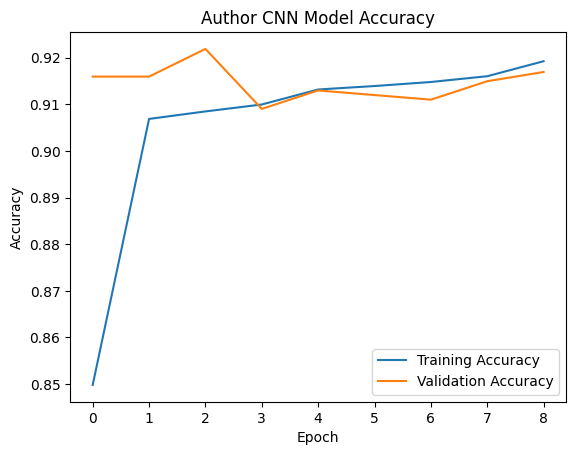

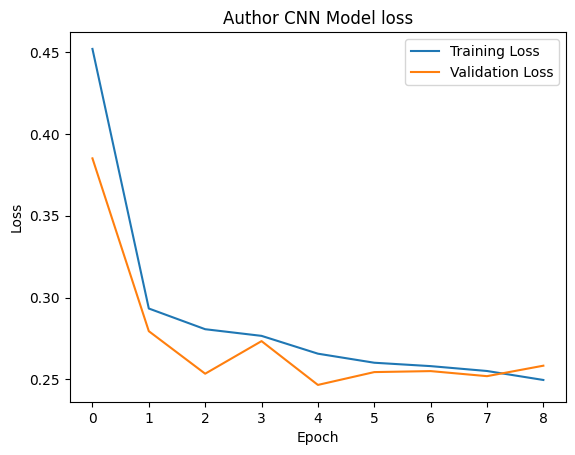

In [ ]:
# Plot training & validation accuracy values
plt.plot(CNN_model_author_fit_1.history['accuracy'])
plt.plot(CNN_model_author_fit_1.history['val_accuracy'])
plt.title('Author CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_model_author_fit_1.history['loss'])
plt.plot(CNN_model_author_fit_1.history['val_loss'])
plt.title('Author CNN Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

#### Confusion Matrix

32/32 [==============================] - 1s 23ms/step


<ipython-input-63-d73635fba1d1>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + label_names)
<ipython-input-63-d73635fba1d1>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + label_names)


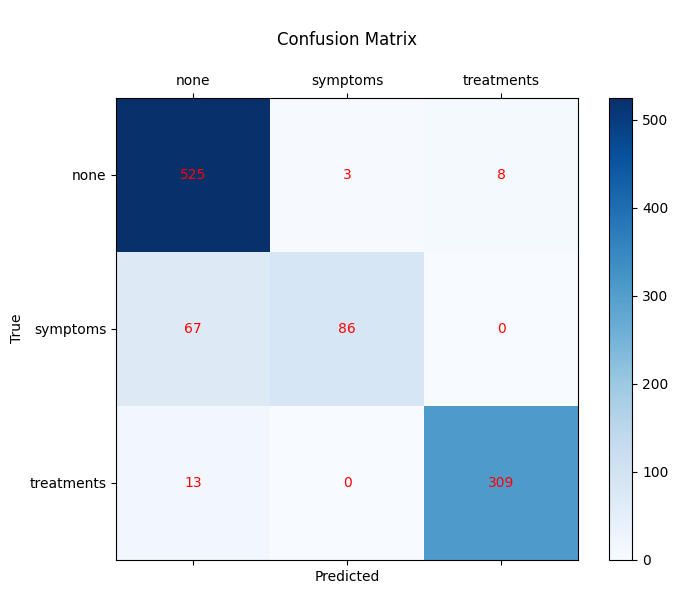

              precision    recall  f1-score   support

        none       0.87      0.98      0.92       536
    symptoms       0.97      0.56      0.71       153
  treatments       0.97      0.96      0.97       322

    accuracy                           0.91      1011
   macro avg       0.94      0.83      0.87      1011
weighted avg       0.92      0.91      0.90      1011



In [ ]:
# Make predictions on the testing data
y_pred = CNN_model_author_1.predict(X_test_1)

# Ensure y_pred is an array of predicted probabilities and get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Use y_val directly as the true labels (assuming y_val is already in the correct shape)
y_true_classes = y_test_1

if len(y_true_classes) != len(y_pred_classes):
    print("Error: The lengths of y_true_classes and y_pred_classes do not match.")
else:
    # Define the mapping from numerical labels to string labels
    label_mapping = {0: 'none', 1: 'symptoms', 2: 'treatments'}
    label_names = ['none', 'symptoms', 'treatments']

    # Map the numerical labels to string labels
    y_true_mapped = [label_mapping[label] for label in y_true_classes]
    y_pred_mapped = [label_mapping[label] for label in y_pred_classes]

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_mapped, y_pred_mapped, labels=label_names)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    plt.title('\nConfusion Matrix\n')
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    ax.set_xticklabels([''] + label_names)
    ax.set_yticklabels([''] + label_names)

    # Add counts to each cell
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, val, ha='center', va='center', color='red')

    plt.show()

    # Print classification report
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))


### Built Using Set 2 Ratio Dataset

In [ ]:
CNN_model_author_2 = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5),
    # ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch,
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
    #It will be added after the activation function between a convolutional and a max-pooling layer.
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(3, activation = 'sigmoid')
])

In [ ]:
CNN_model_author_2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.01), metrics=['accuracy'])

In [ ]:
CNN_model_author_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          10000     
                                                                 
 spatial_dropout1d (Spatial  (None, 100, 100)          0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 100, 100)          40100     
                                                                 
 batch_normalization (Batch  (None, 100, 100)          400       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 global_max_pooling1d (Glob  (None, 100)               0

In [ ]:
CNN_model_author_fit_2 = CNN_model_author_2.fit(X_train_2, y_train_2, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val_2, y_val_2), callbacks=[early])

Epoch 1/15
222/222 [==============================] - 10s 35ms/step - loss: 0.4371 - accuracy: 0.8554 - val_loss: 0.5576 - val_accuracy: 0.8549
Epoch 2/15
222/222 [==============================] - 8s 36ms/step - loss: 0.3024 - accuracy: 0.9054 - val_loss: 0.2854 - val_accuracy: 0.9123
Epoch 3/15
222/222 [==============================] - 7s 32ms/step - loss: 0.2934 - accuracy: 0.9083 - val_loss: 0.2536 - val_accuracy: 0.9189
Epoch 4/15
222/222 [==============================] - 8s 38ms/step - loss: 0.2732 - accuracy: 0.9094 - val_loss: 0.2609 - val_accuracy: 0.9235
Epoch 5/15
222/222 [==============================] - 7s 30ms/step - loss: 0.2800 - accuracy: 0.9084 - val_loss: 0.2427 - val_accuracy: 0.9261
Epoch 6/15
222/222 [==============================] - 9s 40ms/step - loss: 0.2761 - accuracy: 0.9100 - val_loss: 0.2364 - val_accuracy: 0.9248
Epoch 7/15
222/222 [==============================] - 7s 32ms/step - loss: 0.2652 - accuracy: 0.9122 - val_loss: 0.2387 - val_accuracy: 0.921

In [ ]:
CNN_author_train_score_2 = CNN_model_author_2.evaluate(X_train_2, y_train_2, batch_size = batch_size2, verbose = 1)
print('Train loss:', CNN_author_train_score_2[0])
print('Train accuracy:', CNN_author_train_score_2[1])

222/222 [==============================] - 3s 12ms/step - loss: 0.2505 - accuracy: 0.9190
Train loss: 0.2504575848579407
Train accuracy: 0.9189991354942322


In [ ]:
CNN_author_test_score_2 = CNN_model_author_2.evaluate(X_test_2, y_test_2, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_author_test_score_2[0])
print('Test Accuracy:', CNN_author_test_score_2[1])

48/48 [==============================] - 0s 8ms/step - loss: 0.2651 - accuracy: 0.9261
Test Loss: 0.26511523127555847
Test Accuracy: 0.9261213541030884


#### Visualization on Training and Validation Result

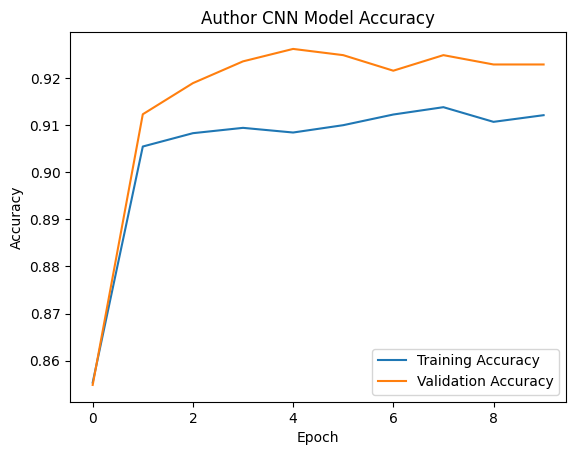

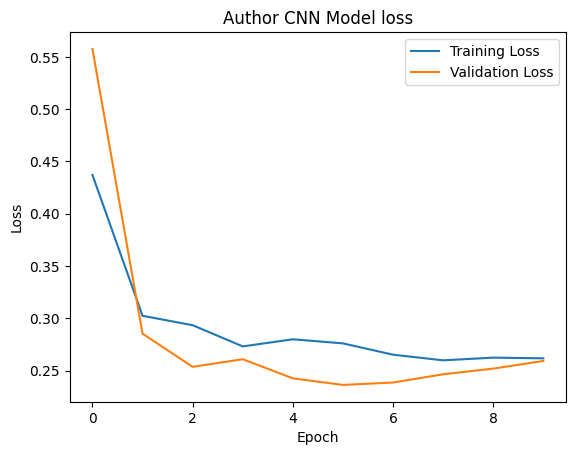

In [ ]:
# Plot training & validation accuracy values
plt.plot(CNN_model_author_fit_2.history['accuracy'])
plt.plot(CNN_model_author_fit_2.history['val_accuracy'])
plt.title('Author CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_model_author_fit_2.history['loss'])
plt.plot(CNN_model_author_fit_2.history['val_loss'])
plt.title('Author CNN Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

#### Confusion Matrix

48/48 [==============================] - 1s 8ms/step


<ipython-input-20-eb13abeb2c0a>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + label_names)
<ipython-input-20-eb13abeb2c0a>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + label_names)


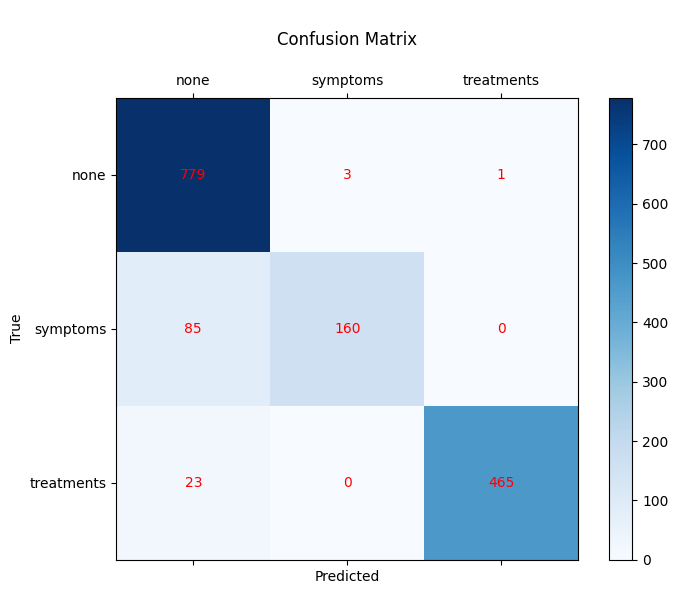

              precision    recall  f1-score   support

        none       0.88      0.99      0.93       783
    symptoms       0.98      0.65      0.78       245
  treatments       1.00      0.95      0.97       488

    accuracy                           0.93      1516
   macro avg       0.95      0.87      0.90      1516
weighted avg       0.93      0.93      0.92      1516



In [ ]:
# Make predictions on the testing data
y_pred = CNN_model_author_2.predict(X_test_2)

# Ensure y_pred is an array of predicted probabilities and get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Use y_val directly as the true labels (assuming y_val is already in the correct shape)
y_true_classes = y_test_2

if len(y_true_classes) != len(y_pred_classes):
    print("Error: The lengths of y_true_classes and y_pred_classes do not match.")
else:
    # Define the mapping from numerical labels to string labels
    label_mapping = {0: 'none', 1: 'symptoms', 2: 'treatments'}
    label_names = ['none', 'symptoms', 'treatments']

    # Map the numerical labels to string labels
    y_true_mapped = [label_mapping[label] for label in y_true_classes]
    y_pred_mapped = [label_mapping[label] for label in y_pred_classes]

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_mapped, y_pred_mapped, labels=label_names)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    plt.title('\nConfusion Matrix\n')
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    ax.set_xticklabels([''] + label_names)
    ax.set_yticklabels([''] + label_names)

    # Add counts to each cell
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, val, ha='center', va='center', color='red')

    plt.show()

    # Print classification report
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))


### Built Using Set 3 Ratio Dataset

In [ ]:
CNN_model_author_3 = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5),
    # ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch,
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
    #It will be added after the activation function between a convolutional and a max-pooling layer.
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(3, activation = 'sigmoid')
])

In [ ]:
CNN_model_author_3.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.01), metrics=['accuracy'])

In [ ]:
CNN_model_author_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          10000     
                                                                 
 spatial_dropout1d_2 (Spati  (None, 100, 100)          0         
 alDropout1D)                                                    
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 100)          40100     
                                                                 
 batch_normalization_2 (Bat  (None, 100, 100)          400       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 100, 100)          0         
                                                                 
 global_max_pooling1d_2 (Gl  (None, 100)              

In [ ]:
CNN_model_author_fit_3 = CNN_model_author_3.fit(X_train_3, y_train_3, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val_3, y_val_3), callbacks=[early])

Epoch 1/15
190/190 [==============================] - 9s 35ms/step - loss: 0.4940 - accuracy: 0.8313 - val_loss: 0.5230 - val_accuracy: 0.9020
Epoch 2/15
190/190 [==============================] - 8s 44ms/step - loss: 0.3038 - accuracy: 0.9063 - val_loss: 0.3076 - val_accuracy: 0.9104
Epoch 3/15
190/190 [==============================] - 7s 35ms/step - loss: 0.2935 - accuracy: 0.9062 - val_loss: 0.2504 - val_accuracy: 0.9223
Epoch 4/15
190/190 [==============================] - 8s 41ms/step - loss: 0.2787 - accuracy: 0.9101 - val_loss: 0.2531 - val_accuracy: 0.9248
Epoch 5/15
190/190 [==============================] - 6s 32ms/step - loss: 0.2736 - accuracy: 0.9096 - val_loss: 0.2364 - val_accuracy: 0.9208
Epoch 6/15
190/190 [==============================] - 11s 58ms/step - loss: 0.2650 - accuracy: 0.9109 - val_loss: 0.2388 - val_accuracy: 0.9213
Epoch 7/15
190/190 [==============================] - 11s 56ms/step - loss: 0.2648 - accuracy: 0.9076 - val_loss: 0.2397 - val_accuracy: 0.91

In [ ]:
X_train_3.shape

(6063, 100)

In [ ]:
CNN_author_train_score_3 = CNN_model_author_3.evaluate(X_train_3, y_train_3, batch_size = batch_size2, verbose = 1)
print('Train loss:', CNN_author_train_score_3[0])
print('Train accuracy:', CNN_author_train_score_3[1])

190/190 [==============================] - 2s 8ms/step - loss: 0.2471 - accuracy: 0.8928
Train loss: 0.24710899591445923
Train accuracy: 0.8927923440933228


In [ ]:
CNN_author_test_score_3 = CNN_model_author_3.evaluate(X_test_3, y_test_3, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_author_test_score_3[0])
print('Test Accuracy:', CNN_author_test_score_3[1])

64/64 [==============================] - 1s 8ms/step - loss: 0.2895 - accuracy: 0.8828
Test Loss: 0.2895018756389618
Test Accuracy: 0.8827893137931824


#### Visualization on Training and Validation Result

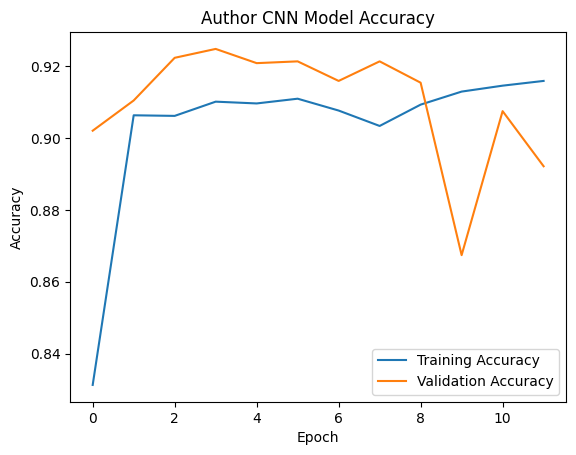

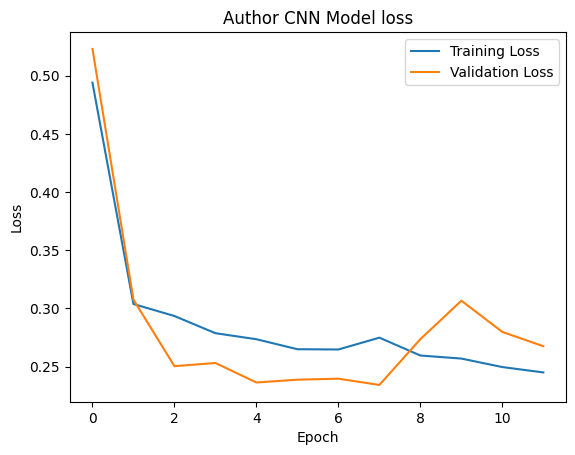

In [ ]:
# Plot training & validation accuracy values
plt.plot(CNN_model_author_fit_3.history['accuracy'])
plt.plot(CNN_model_author_fit_3.history['val_accuracy'])
plt.title('Author CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_model_author_fit_3.history['loss'])
plt.plot(CNN_model_author_fit_3.history['val_loss'])
plt.title('Author CNN Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

#### Confusion Matrix

64/64 [==============================] - 1s 13ms/step


<ipython-input-98-7dd5fab1be7e>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + label_names)
<ipython-input-98-7dd5fab1be7e>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + label_names)


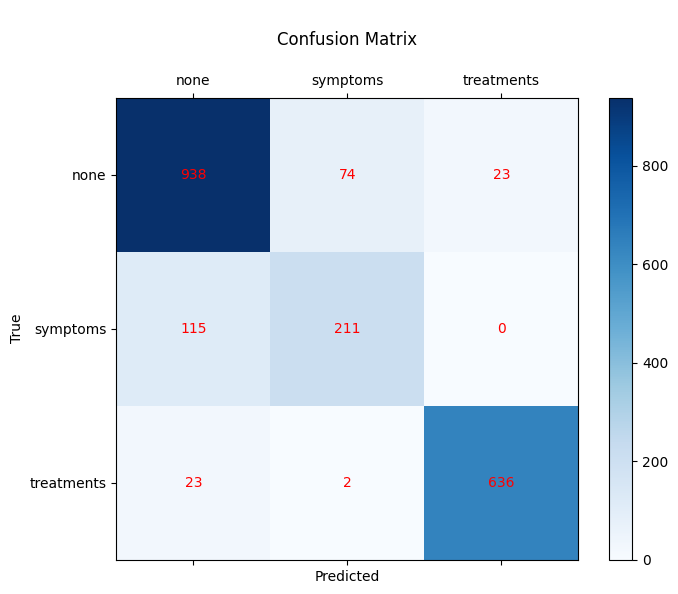

              precision    recall  f1-score   support

        none       0.87      0.91      0.89      1035
    symptoms       0.74      0.65      0.69       326
  treatments       0.97      0.96      0.96       661

    accuracy                           0.88      2022
   macro avg       0.86      0.84      0.85      2022
weighted avg       0.88      0.88      0.88      2022



In [ ]:
# Make predictions on the testing data
y_pred = CNN_model_author_3.predict(X_test_3)

# Ensure y_pred is an array of predicted probabilities and get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Use y_val directly as the true labels (assuming y_val is already in the correct shape)
y_true_classes = y_test_3

if len(y_true_classes) != len(y_pred_classes):
    print("Error: The lengths of y_true_classes and y_pred_classes do not match.")
else:
    # Define the mapping from numerical labels to string labels
    label_mapping = {0: 'none', 1: 'symptoms', 2: 'treatments'}
    label_names = ['none', 'symptoms', 'treatments']

    # Map the numerical labels to string labels
    y_true_mapped = [label_mapping[label] for label in y_true_classes]
    y_pred_mapped = [label_mapping[label] for label in y_pred_classes]

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_mapped, y_pred_mapped, labels=label_names)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    plt.title('\nConfusion Matrix\n')
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    ax.set_xticklabels([''] + label_names)
    ax.set_yticklabels([''] + label_names)

    # Add counts to each cell
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, val, ha='center', va='center', color='red')

    plt.show()

    # Print classification report
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))


## Proposed CNN Model

*    using L2 Regularization (0,01)
*    lower the learning rate to 0.001



### Built Using Set 1 Ratio Dataset

In [ ]:
CNN_proposed_model_1 = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5),
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)),  # Added L2 regularization here
    Dense(3, activation = 'sigmoid', kernel_regularizer=regularizers.l2(0.01))  # And here
])

CNN_proposed_model_1.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
CNN_proposed_model_1.summary()
CNN_proposed_model_fit_1 = CNN_proposed_model_1.fit(X_train_1, y_train_1, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val_1, y_val_1), callbacks=[early])


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          10000     
                                                                 
 spatial_dropout1d_7 (Spati  (None, 100, 100)          0         
 alDropout1D)                                                    
                                                                 
 conv1d_7 (Conv1D)           (None, 100, 100)          40100     
                                                                 
 batch_normalization_7 (Bat  (None, 100, 100)          400       
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 100, 100)          0         
                                                                 
 global_max_pooling1d_7 (Gl  (None, 100)              

In [ ]:
CNN_proposed_train_score_1 = CNN_proposed_model_1.evaluate(X_train_1, y_train_1, batch_size = batch_size2, verbose = 1)
print('Train loss:', CNN_proposed_train_score_1[0])
print('Train accuracy:', CNN_proposed_train_score_1[1])

253/253 [==============================] - 2s 9ms/step - loss: 0.2295 - accuracy: 0.9326
Train loss: 0.22947825491428375
Train accuracy: 0.9325828552246094


In [ ]:
CNN_proposed_test_score_1 = CNN_proposed_model_1.evaluate(X_test_1, y_test_1, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_proposed_test_score_1[0])
print('Test Accuracy:', CNN_proposed_test_score_1[1])

32/32 [==============================] - 0s 8ms/step - loss: 0.2895 - accuracy: 0.9159
Test Loss: 0.28952398896217346
Test Accuracy: 0.9159248471260071


#### Visualization on Training and Validation Result

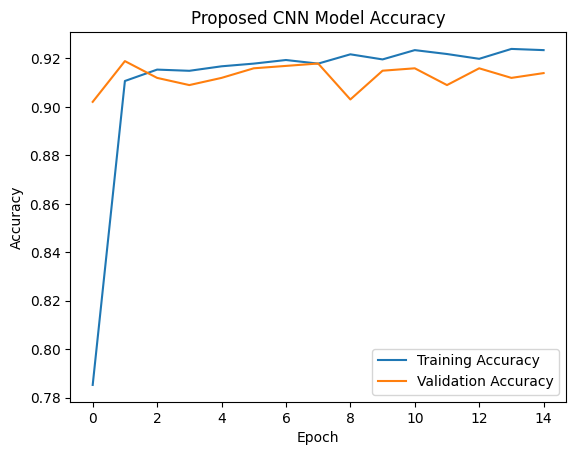

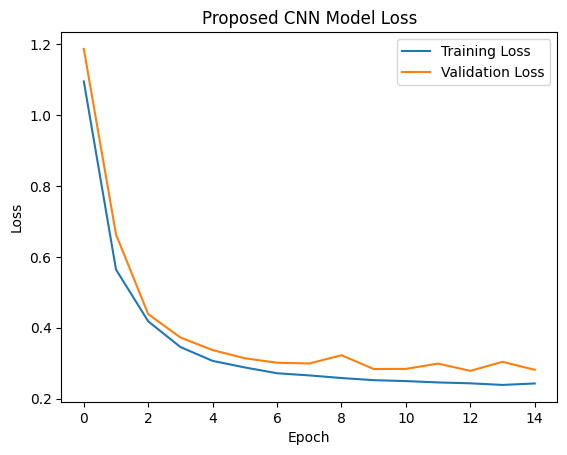

In [ ]:
# Plot training & validation accuracy values
plt.plot(CNN_proposed_model_fit_1.history['accuracy'])
plt.plot(CNN_proposed_model_fit_1.history['val_accuracy'])
plt.title('Proposed CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_proposed_model_fit_1.history['loss'])
plt.plot(CNN_proposed_model_fit_1.history['val_loss'])
plt.title('Proposed CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

#### Confusion Matrix

32/32 [==============================] - 0s 9ms/step


<ipython-input-72-afa482bc3a97>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + label_names)
<ipython-input-72-afa482bc3a97>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + label_names)


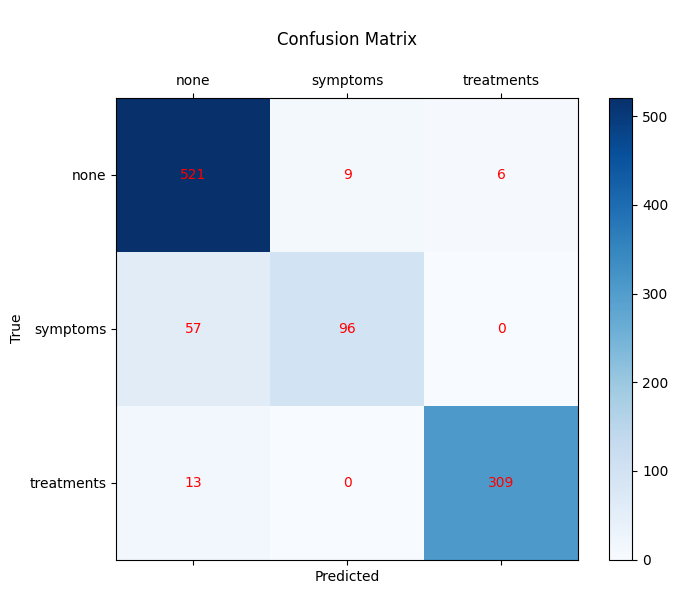

              precision    recall  f1-score   support

        none       0.88      0.97      0.92       536
    symptoms       0.91      0.63      0.74       153
  treatments       0.98      0.96      0.97       322

    accuracy                           0.92      1011
   macro avg       0.93      0.85      0.88      1011
weighted avg       0.92      0.92      0.91      1011



In [ ]:
# Make predictions on the testing data
y_pred = CNN_proposed_model_1.predict(X_test_1)

# Ensure y_pred is an array of predicted probabilities and get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Use y_val directly as the true labels (assuming y_test is already in the correct shape)
y_true_classes = y_test_1

if len(y_true_classes) != len(y_pred_classes):
    print("Error: The lengths of y_true_classes and y_pred_classes do not match.")
else:
    # Define the mapping from numerical labels to string labels
    label_mapping = {0: 'none', 1: 'symptoms', 2: 'treatments'}
    label_names = ['none', 'symptoms', 'treatments']

    # Map the numerical labels to string labels
    y_true_mapped = [label_mapping[label] for label in y_true_classes]
    y_pred_mapped = [label_mapping[label] for label in y_pred_classes]

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_mapped, y_pred_mapped, labels=label_names)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    plt.title('\nConfusion Matrix\n')
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    ax.set_xticklabels([''] + label_names)
    ax.set_yticklabels([''] + label_names)

    # Add counts to each cell
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, val, ha='center', va='center', color='red')

    plt.show()

    # Print classification report
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))


### Built Using Set 2 Ratio Dataset

In [ ]:
CNN_proposed_model_2 = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5),
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)),  # Added L2 regularization here
    Dense(3, activation = 'sigmoid', kernel_regularizer=regularizers.l2(0.01))  # And here
])

CNN_proposed_model_2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
CNN_proposed_model_2.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 100)          10000     
                                                                 
 spatial_dropout1d_10 (Spat  (None, 100, 100)          0         
 ialDropout1D)                                                   
                                                                 
 conv1d_10 (Conv1D)          (None, 100, 100)          40100     
                                                                 
 batch_normalization_10 (Ba  (None, 100, 100)          400       
 tchNormalization)                                               
                                                                 
 dropout_10 (Dropout)        (None, 100, 100)          0         
                                                                 
 global_max_pooling1d_10 (G  (None, 100)             

In [ ]:
CNN_proposed_model_fit_2 = CNN_proposed_model_2.fit(X_train_2, y_train_2, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val_2, y_val_2), callbacks=[early])


Epoch 1/15
222/222 [==============================] - 9s 33ms/step - loss: 1.1672 - accuracy: 0.7707 - val_loss: 1.2862 - val_accuracy: 0.9030
Epoch 2/15
222/222 [==============================] - 9s 39ms/step - loss: 0.6708 - accuracy: 0.8986 - val_loss: 0.8310 - val_accuracy: 0.9215
Epoch 3/15
222/222 [==============================] - 7s 33ms/step - loss: 0.5084 - accuracy: 0.9088 - val_loss: 0.5098 - val_accuracy: 0.9215
Epoch 4/15
222/222 [==============================] - 8s 37ms/step - loss: 0.4034 - accuracy: 0.9131 - val_loss: 0.4097 - val_accuracy: 0.9215
Epoch 5/15
222/222 [==============================] - 7s 31ms/step - loss: 0.3522 - accuracy: 0.9162 - val_loss: 0.3914 - val_accuracy: 0.9109
Epoch 6/15
222/222 [==============================] - 8s 34ms/step - loss: 0.3170 - accuracy: 0.9169 - val_loss: 0.3343 - val_accuracy: 0.9215
Epoch 7/15
222/222 [==============================] - 7s 33ms/step - loss: 0.2968 - accuracy: 0.9160 - val_loss: 0.3133 - val_accuracy: 0.9222

In [ ]:
CNN_proposed_train_score_2 = CNN_proposed_model_2.evaluate(X_train_2, y_train_2, batch_size = batch_size2, verbose = 1)
print('Train loss:', CNN_proposed_train_score_2[0])
print('Train accuracy:', CNN_proposed_train_score_2[1])

222/222 [==============================] - 2s 9ms/step - loss: 0.2442 - accuracy: 0.9273
Train loss: 0.24419279396533966
Train accuracy: 0.9273395538330078


In [ ]:
CNN_proposed_test_score_2 = CNN_proposed_model_2.evaluate(X_test_2, y_test_2, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_proposed_test_score_2[0])
print('Test Accuracy:', CNN_proposed_test_score_2[1])

48/48 [==============================] - 0s 8ms/step - loss: 0.2853 - accuracy: 0.9162
Test Loss: 0.2853192389011383
Test Accuracy: 0.9162269234657288


#### Visualization on Training and Validation Result

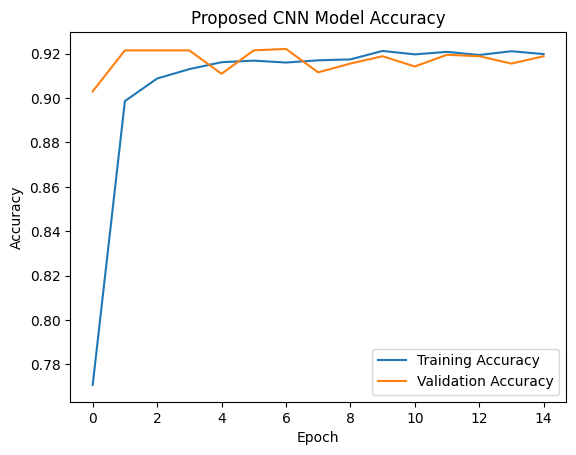

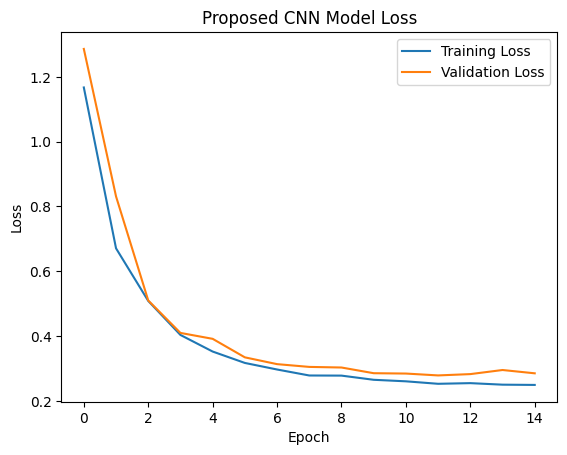

In [ ]:
# Plot training & validation accuracy values
plt.plot(CNN_proposed_model_fit_2.history['accuracy'])
plt.plot(CNN_proposed_model_fit_2.history['val_accuracy'])
plt.title('Proposed CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_proposed_model_fit_2.history['loss'])
plt.plot(CNN_proposed_model_fit_2.history['val_loss'])
plt.title('Proposed CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

#### Confusion Matrix

48/48 [==============================] - 0s 8ms/step


<ipython-input-91-c9267cb3abbb>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + label_names)
<ipython-input-91-c9267cb3abbb>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + label_names)


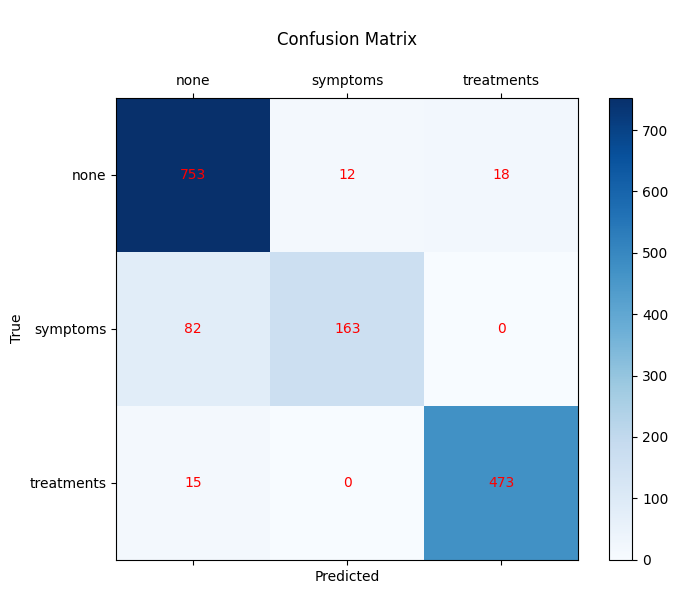

              precision    recall  f1-score   support

        none       0.89      0.96      0.92       783
    symptoms       0.93      0.67      0.78       245
  treatments       0.96      0.97      0.97       488

    accuracy                           0.92      1516
   macro avg       0.93      0.87      0.89      1516
weighted avg       0.92      0.92      0.91      1516



In [ ]:
# Make predictions on the testing data
y_pred = CNN_proposed_model_2.predict(X_test_2)

# Ensure y_pred is an array of predicted probabilities and get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Use y_val directly as the true labels (assuming y_test is already in the correct shape)
y_true_classes = y_test_2

if len(y_true_classes) != len(y_pred_classes):
    print("Error: The lengths of y_true_classes and y_pred_classes do not match.")
else:
    # Define the mapping from numerical labels to string labels
    label_mapping = {0: 'none', 1: 'symptoms', 2: 'treatments'}
    label_names = ['none', 'symptoms', 'treatments']

    # Map the numerical labels to string labels
    y_true_mapped = [label_mapping[label] for label in y_true_classes]
    y_pred_mapped = [label_mapping[label] for label in y_pred_classes]

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_mapped, y_pred_mapped, labels=label_names)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    plt.title('\nConfusion Matrix\n')
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    ax.set_xticklabels([''] + label_names)
    ax.set_yticklabels([''] + label_names)

    # Add counts to each cell
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, val, ha='center', va='center', color='red')

    plt.show()

    # Print classification report
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))


### Built Using Set 3 Ratio Dataset

In [ ]:
CNN_proposed_model_3 = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5),
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)),  # Added L2 regularization here
    Dense(3, activation = 'sigmoid', kernel_regularizer=regularizers.l2(0.01))  # And here
])

CNN_proposed_model_3.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
CNN_proposed_model_3.summary()
CNN_proposed_model_fit_3 = CNN_proposed_model_3.fit(X_train_3, y_train_3, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val_3, y_val_3), callbacks=[early])


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 100)          10000     
                                                                 
 spatial_dropout1d_9 (Spati  (None, 100, 100)          0         
 alDropout1D)                                                    
                                                                 
 conv1d_9 (Conv1D)           (None, 100, 100)          40100     
                                                                 
 batch_normalization_9 (Bat  (None, 100, 100)          400       
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 100, 100)          0         
                                                                 
 global_max_pooling1d_9 (Gl  (None, 100)              

In [ ]:
CNN_proposed_train_score_3 = CNN_proposed_model_3.evaluate(X_train_3, y_train_3, batch_size = batch_size2, verbose = 1)
print('Train loss:', CNN_proposed_train_score_3[0])
print('Train accuracy:', CNN_proposed_train_score_3[1])

190/190 [==============================] - 2s 9ms/step - loss: 0.2434 - accuracy: 0.9339
Train loss: 0.24344317615032196
Train accuracy: 0.9338611364364624


In [ ]:
CNN_proposed_test_score_3 = CNN_proposed_model_3.evaluate(X_test_3, y_test_3, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_proposed_test_score_3[0])
print('Test Accuracy:', CNN_proposed_test_score_3[1])

64/64 [==============================] - 1s 9ms/step - loss: 0.2976 - accuracy: 0.9120
Test Loss: 0.29759714007377625
Test Accuracy: 0.9119683504104614


#### Visualization on Testing and Validation Result

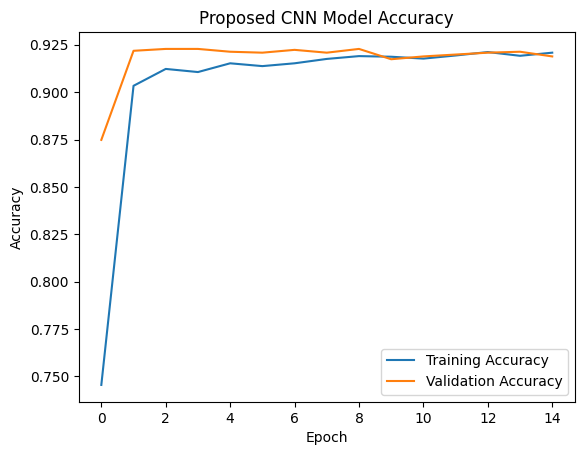

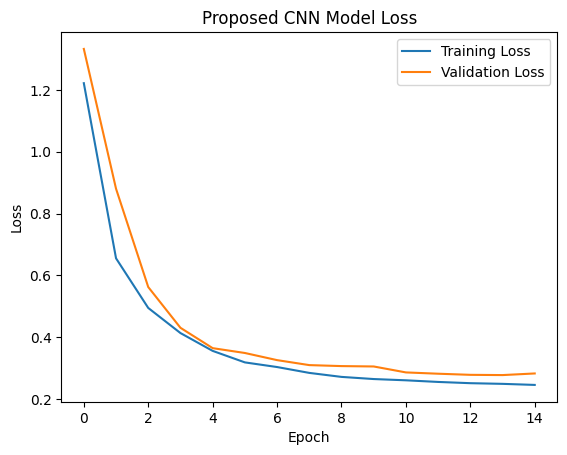

In [ ]:
# Plot training & validation accuracy values
plt.plot(CNN_proposed_model_fit_3.history['accuracy'])
plt.plot(CNN_proposed_model_fit_3.history['val_accuracy'])
plt.title('Proposed CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_proposed_model_fit_3.history['loss'])
plt.plot(CNN_proposed_model_fit_3.history['val_loss'])
plt.title('Proposed CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

#### Confusion Matrix

64/64 [==============================] - 1s 14ms/step


<ipython-input-85-88d84bc11ce5>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + label_names)
<ipython-input-85-88d84bc11ce5>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + label_names)


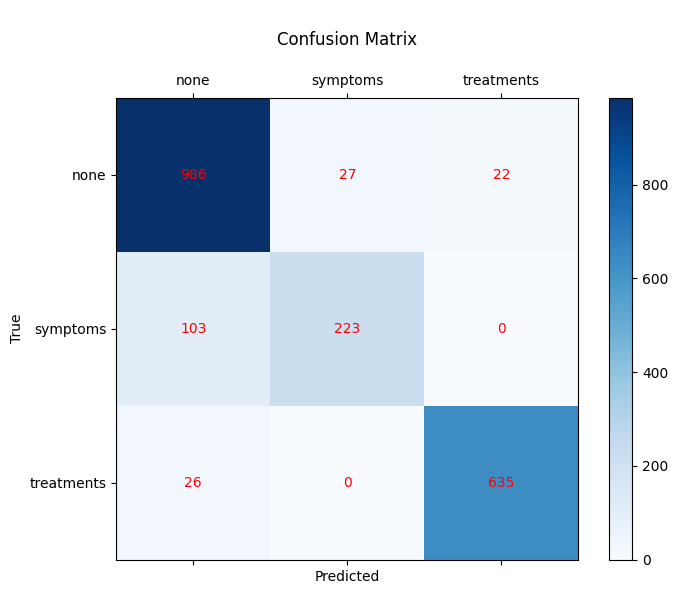

              precision    recall  f1-score   support

        none       0.88      0.95      0.92      1035
    symptoms       0.89      0.68      0.77       326
  treatments       0.97      0.96      0.96       661

    accuracy                           0.91      2022
   macro avg       0.91      0.87      0.89      2022
weighted avg       0.91      0.91      0.91      2022



In [ ]:
# Make predictions on the testing data
y_pred = CNN_proposed_model_3.predict(X_test_3)

# Ensure y_pred is an array of predicted probabilities and get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Use y_val directly as the true labels (assuming y_test is already in the correct shape)
y_true_classes = y_test_3

if len(y_true_classes) != len(y_pred_classes):
    print("Error: The lengths of y_true_classes and y_pred_classes do not match.")
else:
    # Define the mapping from numerical labels to string labels
    label_mapping = {0: 'none', 1: 'symptoms', 2: 'treatments'}
    label_names = ['none', 'symptoms', 'treatments']

    # Map the numerical labels to string labels
    y_true_mapped = [label_mapping[label] for label in y_true_classes]
    y_pred_mapped = [label_mapping[label] for label in y_pred_classes]

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_mapped, y_pred_mapped, labels=label_names)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    plt.title('\nConfusion Matrix\n')
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    ax.set_xticklabels([''] + label_names)
    ax.set_yticklabels([''] + label_names)

    # Add counts to each cell
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, val, ha='center', va='center', color='red')

    plt.show()

    # Print classification report
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))


## Proposed CNN + Word2Vec Embedding


### Built Using Set 1 Ratio Dataset

Building Word2Vec Embedding (with trainable set to True)

In [ ]:
# Define the Word2Vec model
sentences = [tokenizer.sequences_to_texts([sequence])[0].split() for sequence in X_train_1]
#train word2vec model
embedding_dims = 100 #embedding vector output dimension
max_len = 100 #Max. number of words per toxic comment to be use
word2VecModel = gensim.models.Word2Vec(sentences, vector_size= embedding_dims, window=5, workers=4, min_count=1)
# Get the vocabulary size
words = list(word2VecModel.wv.key_to_index)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 99


In [ ]:
# Get vocabulary from Word2Vec model
vocabulary = word2VecModel.wv.index_to_key

# Initialize embedding matrix
num_words = len(vocabulary) + 1  # Add 1 for padding token
embedding_matrix = np.zeros((num_words, embedding_dims))

# Fill embedding matrix
for i, word in enumerate(vocabulary):
    if word in word2VecModel.wv:
        embedding_matrix[i] = word2VecModel.wv[word]

# Optionally handle missing words (out of vocabulary)

# Print shape of embedding matrix
print("Shape of embedding matrix:", embedding_matrix.shape)

Shape of embedding matrix: (100, 100)


In [ ]:
CNN_Word2Vec_model_1 = Sequential([
    Embedding(input_dim =embedding_matrix.shape[0], input_length=max_len, output_dim=embedding_matrix.shape[1],weights=[embedding_matrix], trainable=True),
    SpatialDropout1D(0.5),
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)),  # Added L2 regularization here
    Dense(3, activation = 'sigmoid', kernel_regularizer=regularizers.l2(0.01))  # And here
])

CNN_Word2Vec_model_1.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
CNN_Word2Vec_model_1.summary()
CNN_Word2Vec_model_fit_1 = CNN_Word2Vec_model_1.fit(X_train_1, y_train_1, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val_1, y_val_1), callbacks=[early])

In [ ]:
CNN_Word2Vec_model_1.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
CNN_Word2Vec_model_1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 100)          10000     
                                                                 
 spatial_dropout1d_11 (Spat  (None, 100, 100)          0         
 ialDropout1D)                                                   
                                                                 
 conv1d_11 (Conv1D)          (None, 100, 100)          40100     
                                                                 
 batch_normalization_11 (Ba  (None, 100, 100)          400       
 tchNormalization)                                               
                                                                 
 dropout_11 (Dropout)        (None, 100, 100)          0         
                                                                 
 global_max_pooling1d_11 (G  (None, 100)             

In [ ]:
CNN_Word2Vec_model_fit_1 = CNN_Word2Vec_model_1.fit(X_train_1, y_train_1, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val_1, y_val_1), callbacks=[early])

Epoch 1/15
253/253 [==============================] - 10s 34ms/step - loss: 1.7448 - accuracy: 0.4855 - val_loss: 1.4176 - val_accuracy: 0.7329
Epoch 2/15
253/253 [==============================] - 9s 34ms/step - loss: 0.9575 - accuracy: 0.7561 - val_loss: 0.8318 - val_accuracy: 0.8318
Epoch 3/15
253/253 [==============================] - 7s 28ms/step - loss: 0.6257 - accuracy: 0.8586 - val_loss: 0.5267 - val_accuracy: 0.9110
Epoch 4/15
253/253 [==============================] - 9s 35ms/step - loss: 0.4636 - accuracy: 0.9026 - val_loss: 0.4539 - val_accuracy: 0.9080
Epoch 5/15
253/253 [==============================] - 8s 33ms/step - loss: 0.3896 - accuracy: 0.9093 - val_loss: 0.3789 - val_accuracy: 0.9139
Epoch 6/15
253/253 [==============================] - 9s 37ms/step - loss: 0.3482 - accuracy: 0.9151 - val_loss: 0.3768 - val_accuracy: 0.9179
Epoch 7/15
253/253 [==============================] - 9s 36ms/step - loss: 0.3220 - accuracy: 0.9156 - val_loss: 0.3298 - val_accuracy: 0.916

In [ ]:
CNN_Word2Vec_train_score_1 = CNN_Word2Vec_model_1.evaluate(X_train_1, y_train_1, batch_size=batch_size2, verbose=1)
print('Train Loss:', CNN_Word2Vec_train_score_1[0])
print('Train Accuracy:', CNN_Word2Vec_train_score_1[1])

253/253 [==============================] - 3s 10ms/step - loss: 0.2599 - accuracy: 0.9249
Train Loss: 0.25994446873664856
Train Accuracy: 0.9249134063720703


In [ ]:
CNN_Word2Vec_test_score_1 = CNN_Word2Vec_model_1.evaluate(X_test_1, y_test_1, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_Word2Vec_test_score_1[0])
print('Test Accuracy:', CNN_Word2Vec_test_score_1[1])

32/32 [==============================] - 0s 9ms/step - loss: 0.2923 - accuracy: 0.9159
Test Loss: 0.2923445999622345
Test Accuracy: 0.9159248471260071


#### Visualization on Training and Validation Result

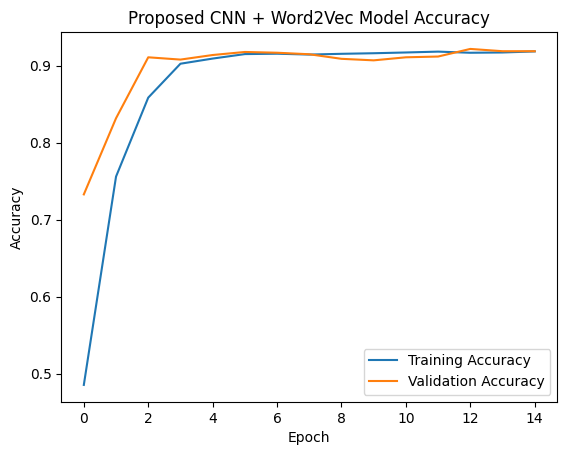

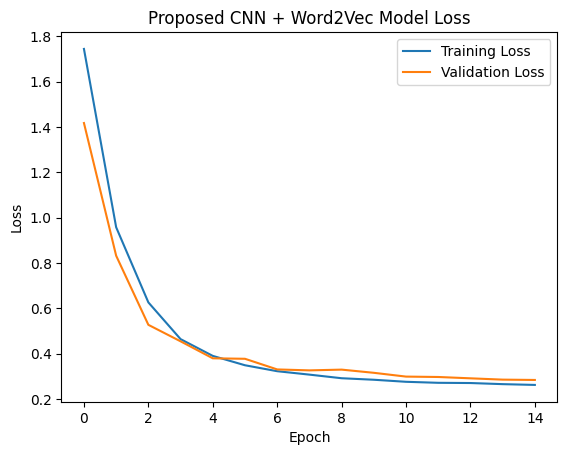

In [ ]:
# Plot training & validation accuracy values
plt.plot(CNN_Word2Vec_model_fit_1.history['accuracy'])
plt.plot(CNN_Word2Vec_model_fit_1.history['val_accuracy'])
plt.title('Proposed CNN + Word2Vec Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_Word2Vec_model_fit_1.history['loss'])
plt.plot(CNN_Word2Vec_model_fit_1.history['val_loss'])
plt.title('Proposed CNN + Word2Vec Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

#### Confusion Matrix

32/32 [==============================] - 0s 9ms/step


<ipython-input-101-dee52f8e3cba>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + label_names)
<ipython-input-101-dee52f8e3cba>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + label_names)


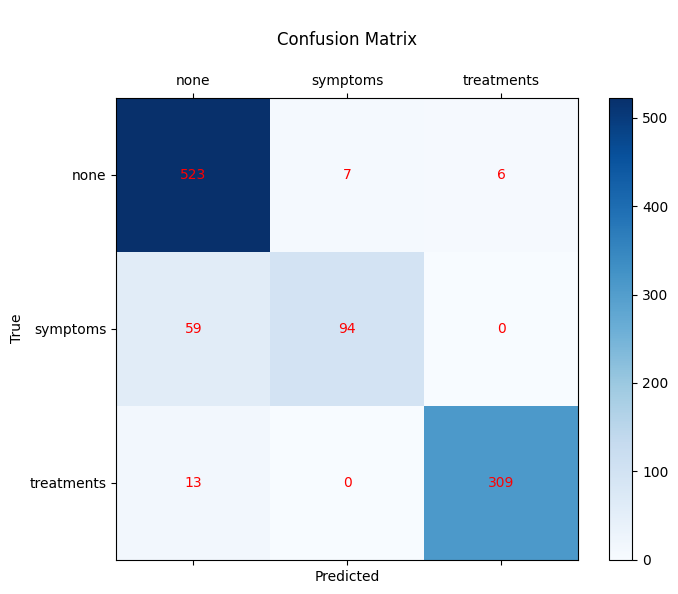

              precision    recall  f1-score   support

        none       0.88      0.98      0.92       536
    symptoms       0.93      0.61      0.74       153
  treatments       0.98      0.96      0.97       322

    accuracy                           0.92      1011
   macro avg       0.93      0.85      0.88      1011
weighted avg       0.92      0.92      0.91      1011



In [ ]:
# Make predictions on the testing data
y_pred = CNN_Word2Vec_model_1.predict(X_test_1)

# Ensure y_pred is an array of predicted probabilities and get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Use y_val directly as the true labels (assuming y_val is already in the correct shape)
y_true_classes = y_test_1

if len(y_true_classes) != len(y_pred_classes):
    print("Error: The lengths of y_true_classes and y_pred_classes do not match.")
else:
    # Define the mapping from numerical labels to string labels
    label_mapping = {0: 'none', 1: 'symptoms', 2: 'treatments'}
    label_names = ['none', 'symptoms', 'treatments']

    # Map the numerical labels to string labels
    y_true_mapped = [label_mapping[label] for label in y_true_classes]
    y_pred_mapped = [label_mapping[label] for label in y_pred_classes]

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_mapped, y_pred_mapped, labels=label_names)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    plt.title('\nConfusion Matrix\n')
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    ax.set_xticklabels([''] + label_names)
    ax.set_yticklabels([''] + label_names)

    # Add counts to each cell
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, val, ha='center', va='center', color='red')

    plt.show()

    # Print classification report
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))


### Built Using Set 2 Ratio Dataset

In [ ]:
# Define the Word2Vec model
sentences = [tokenizer.sequences_to_texts([sequence])[0].split() for sequence in X_train_2]
#train word2vec model
embedding_dims = 100 #embedding vector output dimension
max_len = 100 #Max. number of words per toxic comment to be use
word2VecModel = gensim.models.Word2Vec(sentences, vector_size= embedding_dims, window=5, workers=4, min_count=1)
# Get the vocabulary size
words = list(word2VecModel.wv.key_to_index)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 99


In [ ]:
# Get vocabulary from Word2Vec model
vocabulary = word2VecModel.wv.index_to_key

# Initialize embedding matrix
num_words = len(vocabulary) + 1  # Add 1 for padding token
embedding_matrix = np.zeros((num_words, embedding_dims))

# Fill embedding matrix
for i, word in enumerate(vocabulary):
    if word in word2VecModel.wv:
        embedding_matrix[i] = word2VecModel.wv[word]

# Optionally handle missing words (out of vocabulary)

# Print shape of embedding matrix
print("Shape of embedding matrix:", embedding_matrix.shape)

Shape of embedding matrix: (100, 100)


In [ ]:
CNN_Word2Vec_model_2 = Sequential([
    Embedding(input_dim =embedding_matrix.shape[0], input_length=max_len, output_dim=embedding_matrix.shape[1],weights=[embedding_matrix], trainable=True),
    SpatialDropout1D(0.5),
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)),  # Added L2 regularization here
    Dense(3, activation = 'sigmoid', kernel_regularizer=regularizers.l2(0.01))  # And here
])

In [ ]:
CNN_Word2Vec_model_2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
CNN_Word2Vec_model_2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 100, 100)          10000     
                                                                 
 spatial_dropout1d_14 (Spat  (None, 100, 100)          0         
 ialDropout1D)                                                   
                                                                 
 conv1d_14 (Conv1D)          (None, 100, 100)          40100     
                                                                 
 batch_normalization_14 (Ba  (None, 100, 100)          400       
 tchNormalization)                                               
                                                                 
 dropout_14 (Dropout)        (None, 100, 100)          0         
                                                                 
 global_max_pooling1d_14 (G  (None, 100)             

In [ ]:
CNN_Word2Vec_model_fit_2 = CNN_Word2Vec_model_2.fit(X_train_2, y_train_2, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val_2, y_val_2), callbacks=[early])

Epoch 1/15
222/222 [==============================] - 8s 31ms/step - loss: 1.6324 - accuracy: 0.5079 - val_loss: 1.3700 - val_accuracy: 0.7540
Epoch 2/15
222/222 [==============================] - 8s 37ms/step - loss: 0.8949 - accuracy: 0.7718 - val_loss: 0.7425 - val_accuracy: 0.8483
Epoch 3/15
222/222 [==============================] - 7s 32ms/step - loss: 0.5607 - accuracy: 0.8793 - val_loss: 0.4992 - val_accuracy: 0.9215
Epoch 4/15
222/222 [==============================] - 8s 36ms/step - loss: 0.4327 - accuracy: 0.9032 - val_loss: 0.4146 - val_accuracy: 0.9182
Epoch 5/15
222/222 [==============================] - 8s 36ms/step - loss: 0.3826 - accuracy: 0.9056 - val_loss: 0.3780 - val_accuracy: 0.9189
Epoch 6/15
222/222 [==============================] - 7s 31ms/step - loss: 0.3388 - accuracy: 0.9108 - val_loss: 0.3675 - val_accuracy: 0.9169
Epoch 7/15
222/222 [==============================] - 8s 38ms/step - loss: 0.3181 - accuracy: 0.9109 - val_loss: 0.3563 - val_accuracy: 0.9136

In [ ]:
CNN_Word2Vec_train_score_2 = CNN_Word2Vec_model_2.evaluate(X_train_2, y_train_2, batch_size=batch_size2, verbose=1)
print('Train Loss:', CNN_Word2Vec_train_score_2[0])
print('Train Accuracy:', CNN_Word2Vec_train_score_2[1])

222/222 [==============================] - 3s 13ms/step - loss: 0.2669 - accuracy: 0.9237
Train Loss: 0.26691216230392456
Train Accuracy: 0.9236640930175781


In [ ]:
CNN_Word2Vec_test_score_2 = CNN_Word2Vec_model_2.evaluate(X_test_2, y_test_2, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_Word2Vec_test_score_2[0])
print('Test Accuracy:', CNN_Word2Vec_test_score_2[1])

48/48 [==============================] - 0s 8ms/step - loss: 0.2814 - accuracy: 0.9195
Test Loss: 0.28143811225891113
Test Accuracy: 0.9195250868797302


#### Visualization on Training and Validation Result

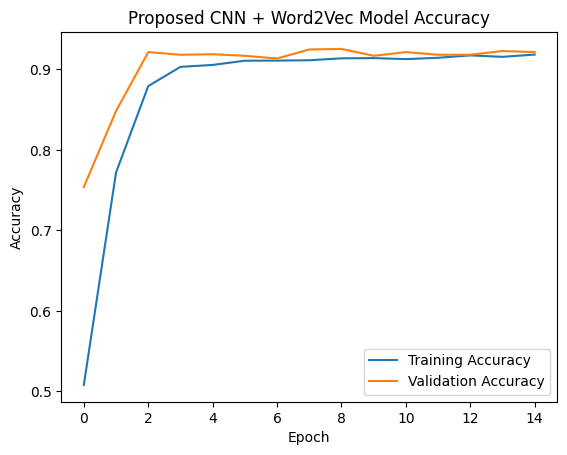

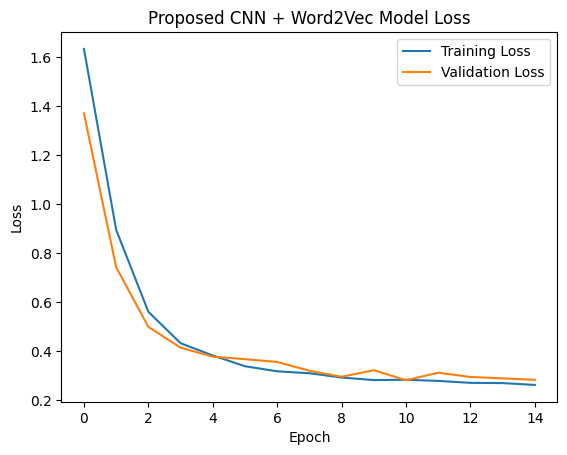

In [ ]:
# Plot training & validation accuracy values
plt.plot(CNN_Word2Vec_model_fit_2.history['accuracy'])
plt.plot(CNN_Word2Vec_model_fit_2.history['val_accuracy'])
plt.title('Proposed CNN + Word2Vec Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_Word2Vec_model_fit_2.history['loss'])
plt.plot(CNN_Word2Vec_model_fit_2.history['val_loss'])
plt.title('Proposed CNN + Word2Vec Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

#### Confusion Matrix

48/48 [==============================] - 0s 8ms/step


<ipython-input-131-53defdeff2fd>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + label_names)
<ipython-input-131-53defdeff2fd>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + label_names)


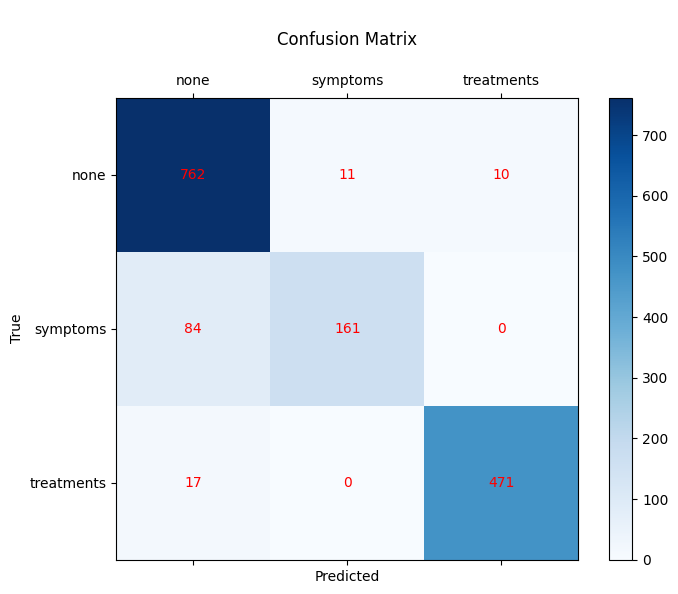

              precision    recall  f1-score   support

        none       0.88      0.97      0.93       783
    symptoms       0.94      0.66      0.77       245
  treatments       0.98      0.97      0.97       488

    accuracy                           0.92      1516
   macro avg       0.93      0.87      0.89      1516
weighted avg       0.92      0.92      0.92      1516



In [ ]:
# Make predictions on the testing data
y_pred = CNN_Word2Vec_model_2.predict(X_test_2)

# Ensure y_pred is an array of predicted probabilities and get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Use y_val directly as the true labels (assuming y_val is already in the correct shape)
y_true_classes = y_test_2

if len(y_true_classes) != len(y_pred_classes):
    print("Error: The lengths of y_true_classes and y_pred_classes do not match.")
else:
    # Define the mapping from numerical labels to string labels
    label_mapping = {0: 'none', 1: 'symptoms', 2: 'treatments'}
    label_names = ['none', 'symptoms', 'treatments']

    # Map the numerical labels to string labels
    y_true_mapped = [label_mapping[label] for label in y_true_classes]
    y_pred_mapped = [label_mapping[label] for label in y_pred_classes]

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_mapped, y_pred_mapped, labels=label_names)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    plt.title('\nConfusion Matrix\n')
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    ax.set_xticklabels([''] + label_names)
    ax.set_yticklabels([''] + label_names)

    # Add counts to each cell
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, val, ha='center', va='center', color='red')

    plt.show()

    # Print classification report
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))


### Built Using Set 3 Ratio Dataset

In [ ]:
# Define the Word2Vec model
sentences = [tokenizer.sequences_to_texts([sequence])[0].split() for sequence in X_train_3]
#train word2vec model
embedding_dims = 100 #embedding vector output dimension
max_len = 100 #Max. number of words per toxic comment to be use
word2VecModel = gensim.models.Word2Vec(sentences, vector_size= embedding_dims, window=5, workers=4, min_count=1)
# Get the vocabulary size
words = list(word2VecModel.wv.key_to_index)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 99


In [ ]:
# Get vocabulary from Word2Vec model
vocabulary = word2VecModel.wv.index_to_key

# Initialize embedding matrix
num_words = len(vocabulary) + 1  # Add 1 for padding token
embedding_matrix = np.zeros((num_words, embedding_dims))

# Fill embedding matrix
for i, word in enumerate(vocabulary):
    if word in word2VecModel.wv:
        embedding_matrix[i] = word2VecModel.wv[word]

# Optionally handle missing words (out of vocabulary)

# Print shape of embedding matrix
print("Shape of embedding matrix:", embedding_matrix.shape)

Shape of embedding matrix: (100, 100)


In [ ]:
CNN_Word2Vec_model_3 = Sequential([
    Embedding(input_dim =embedding_matrix.shape[0], input_length=max_len, output_dim=embedding_matrix.shape[1],weights=[embedding_matrix], trainable=True),
    SpatialDropout1D(0.5),
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)),  # Added L2 regularization here
    Dense(3, activation = 'sigmoid', kernel_regularizer=regularizers.l2(0.01))  # And here
])

In [ ]:
CNN_Word2Vec_model_3.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
CNN_Word2Vec_model_3.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 100, 100)          10000     
                                                                 
 spatial_dropout1d_13 (Spat  (None, 100, 100)          0         
 ialDropout1D)                                                   
                                                                 
 conv1d_13 (Conv1D)          (None, 100, 100)          40100     
                                                                 
 batch_normalization_13 (Ba  (None, 100, 100)          400       
 tchNormalization)                                               
                                                                 
 dropout_13 (Dropout)        (None, 100, 100)          0         
                                                                 
 global_max_pooling1d_13 (G  (None, 100)             

In [ ]:
CNN_Word2Vec_model_fit_3 = CNN_Word2Vec_model_3.fit(X_train_3, y_train_3, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val_3, y_val_3), callbacks=[early])

Epoch 1/15
190/190 [==============================] - 8s 34ms/step - loss: 1.7647 - accuracy: 0.4608 - val_loss: 1.5697 - val_accuracy: 0.7338
Epoch 2/15
190/190 [==============================] - 8s 42ms/step - loss: 1.0325 - accuracy: 0.7569 - val_loss: 0.9017 - val_accuracy: 0.8798
Epoch 3/15
190/190 [==============================] - 6s 31ms/step - loss: 0.6501 - accuracy: 0.8826 - val_loss: 0.6230 - val_accuracy: 0.9104
Epoch 4/15
190/190 [==============================] - 8s 41ms/step - loss: 0.5154 - accuracy: 0.9032 - val_loss: 0.4884 - val_accuracy: 0.9218
Epoch 5/15
190/190 [==============================] - 6s 32ms/step - loss: 0.4350 - accuracy: 0.9076 - val_loss: 0.4832 - val_accuracy: 0.9099
Epoch 6/15
190/190 [==============================] - 7s 38ms/step - loss: 0.3798 - accuracy: 0.9104 - val_loss: 0.3987 - val_accuracy: 0.9179
Epoch 7/15
190/190 [==============================] - 6s 33ms/step - loss: 0.3470 - accuracy: 0.9088 - val_loss: 0.3793 - val_accuracy: 0.9179

In [ ]:
CNN_Word2Vec_train_score_3 = CNN_Word2Vec_model_3.evaluate(X_train_3, y_train_3, batch_size=batch_size2, verbose=1)
print('Train Loss:', CNN_Word2Vec_train_score_3[0])
print('Train Accuracy:', CNN_Word2Vec_train_score_3[1])

190/190 [==============================] - 2s 8ms/step - loss: 0.2635 - accuracy: 0.9238
Train Loss: 0.26353245973587036
Train Accuracy: 0.9238001108169556


In [ ]:
CNN_Word2Vec_test_score_3 = CNN_Word2Vec_model_3.evaluate(X_test_3, y_test_3, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_Word2Vec_test_score_3[0])
print('Test Accuracy:', CNN_Word2Vec_test_score_3[1])

64/64 [==============================] - 1s 12ms/step - loss: 0.2914 - accuracy: 0.9159
Test Loss: 0.29140138626098633
Test Accuracy: 0.9159248471260071


#### Visualization on Training and Validation Result

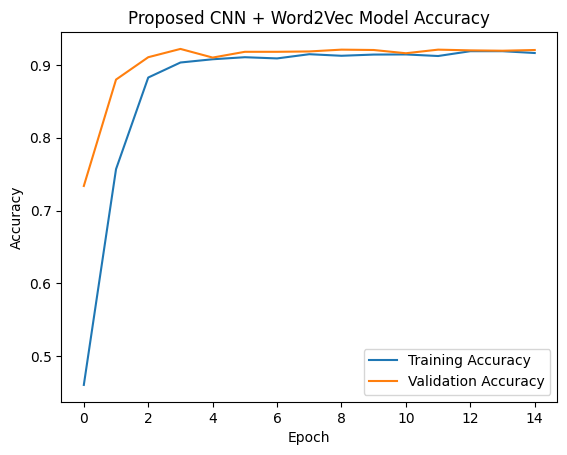

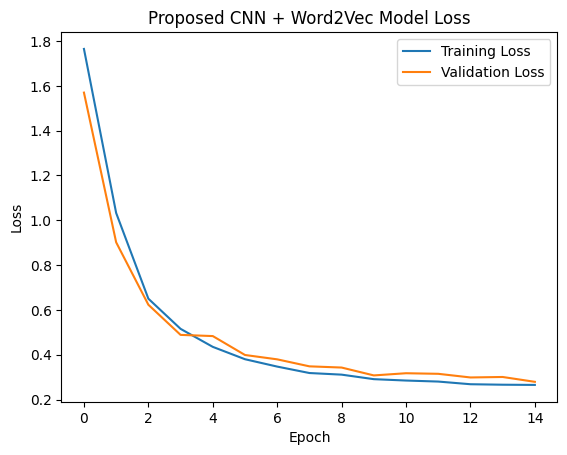

In [ ]:
# Plot training & validation accuracy values
plt.plot(CNN_Word2Vec_model_fit_3.history['accuracy'])
plt.plot(CNN_Word2Vec_model_fit_3.history['val_accuracy'])
plt.title('Proposed CNN + Word2Vec Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_Word2Vec_model_fit_3.history['loss'])
plt.plot(CNN_Word2Vec_model_fit_3.history['val_loss'])
plt.title('Proposed CNN + Word2Vec Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

#### Confusion Matrix

64/64 [==============================] - 1s 8ms/step


<ipython-input-121-b9ac2ed2234f>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + label_names)
<ipython-input-121-b9ac2ed2234f>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + label_names)


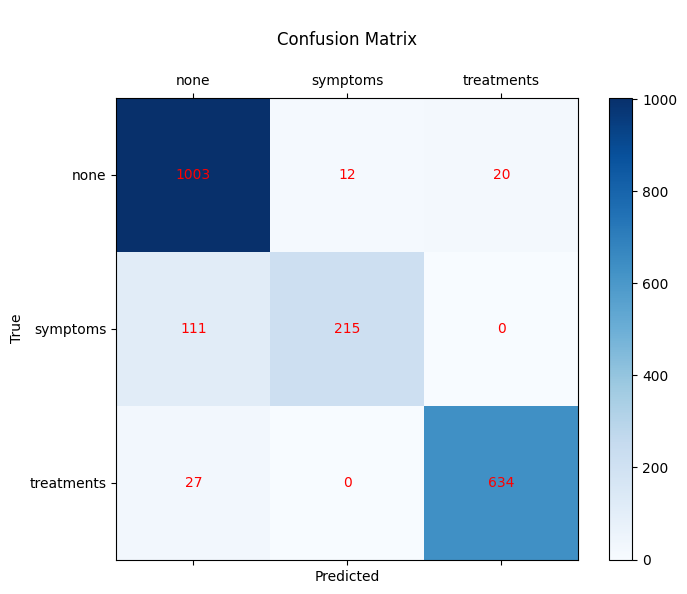

              precision    recall  f1-score   support

        none       0.88      0.97      0.92      1035
    symptoms       0.95      0.66      0.78       326
  treatments       0.97      0.96      0.96       661

    accuracy                           0.92      2022
   macro avg       0.93      0.86      0.89      2022
weighted avg       0.92      0.92      0.91      2022



In [ ]:
# Make predictions on the testing data
y_pred = CNN_Word2Vec_model_3.predict(X_test_3)

# Ensure y_pred is an array of predicted probabilities and get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Use y_val directly as the true labels (assuming y_val is already in the correct shape)
y_true_classes = y_test_3

if len(y_true_classes) != len(y_pred_classes):
    print("Error: The lengths of y_true_classes and y_pred_classes do not match.")
else:
    # Define the mapping from numerical labels to string labels
    label_mapping = {0: 'none', 1: 'symptoms', 2: 'treatments'}
    label_names = ['none', 'symptoms', 'treatments']

    # Map the numerical labels to string labels
    y_true_mapped = [label_mapping[label] for label in y_true_classes]
    y_pred_mapped = [label_mapping[label] for label in y_pred_classes]

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_mapped, y_pred_mapped, labels=label_names)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    plt.title('\nConfusion Matrix\n')
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    ax.set_xticklabels([''] + label_names)
    ax.set_yticklabels([''] + label_names)

    # Add counts to each cell
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, val, ha='center', va='center', color='red')

    plt.show()

    # Print classification report
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))
